## Лабораторная работа № 2. Exploratory Data Analysis и линейная регрессия

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а также привыкнем к основным понятиям машинного обучения.

<strong style="color: red">Внимание!</strong> В этом ноутбуке используется библиотека `ipyleaflet`. Чтобы ее установить так, чтобы она работала, нужно совершить 2 простых шага:

In [303]:
# %%bash
# pip3 install ipyleaflet
# jupyter nbextension enable --py --sys-prefix ipyleaflet

После этого перезапустите сессию (не `Restart Kernel`, а нажмите `Ctrl+C` в терминале, где вы запускали ноутбук, и запустите заново). Лучше это сделать сразу, чтобы потом не пришлось прерывать сессию и терять промежуточные результаты работы. Если все сделано правильно, вы должны увидеть карту Москвы, выполнив ячейку ниже:

In [304]:
# !pip install ipyleaflet

In [305]:
# !jupyter nbextension enable --py --sys-prefix ipyleaflet

In [306]:
from ipyleaflet import Map, basemaps
Map(center=(55.7522200, 37.6155600), zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

Map(center=[55.75222, 37.61556], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## Часть 0.

**Задание 1.**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [308]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data = pd.read_csv('train.csv')
data.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [309]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
data.drop('dropoff_datetime', axis=1, inplace=True)
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data.head(5)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Разбейте выборку на обучающую и тестовую в отношении 7:3.

In [310]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_data = data.iloc[:int(0.7 * len(data))].copy()
test_data = data.iloc[int(0.7 * len(data)):].copy()

Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

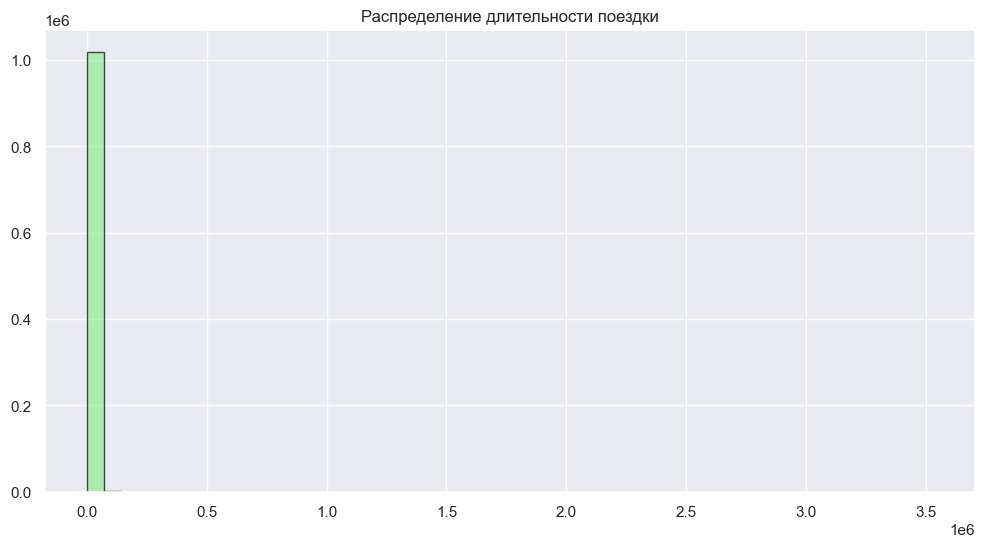

In [311]:
target = 'trip_duration'
plt.figure(figsize=(12, 6))
plt.hist(train_data[target], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title('Распределение длительности поездки')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

У логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашим выборкам колонки `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке:

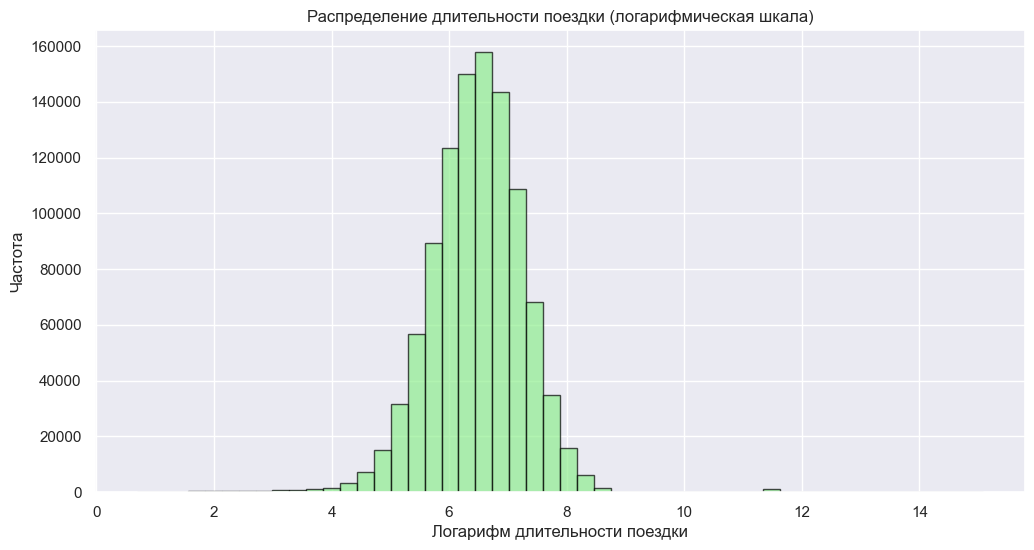

In [312]:
target = 'trip_duration'
plt.figure(figsize=(12, 6))
plt.hist(np.log1p(train_data[target]), bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Частота')
plt.title('Распределение длительности поездки (логарифмическая шкала)')
plt.show()

## Часть 1. Изучаем `pickup_datetime`

**Задание 2.**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

C:\Users\ivan\AppData\Local\Temp\ipykernel_1532\2291725753.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='day_of_year', palette='viridis')


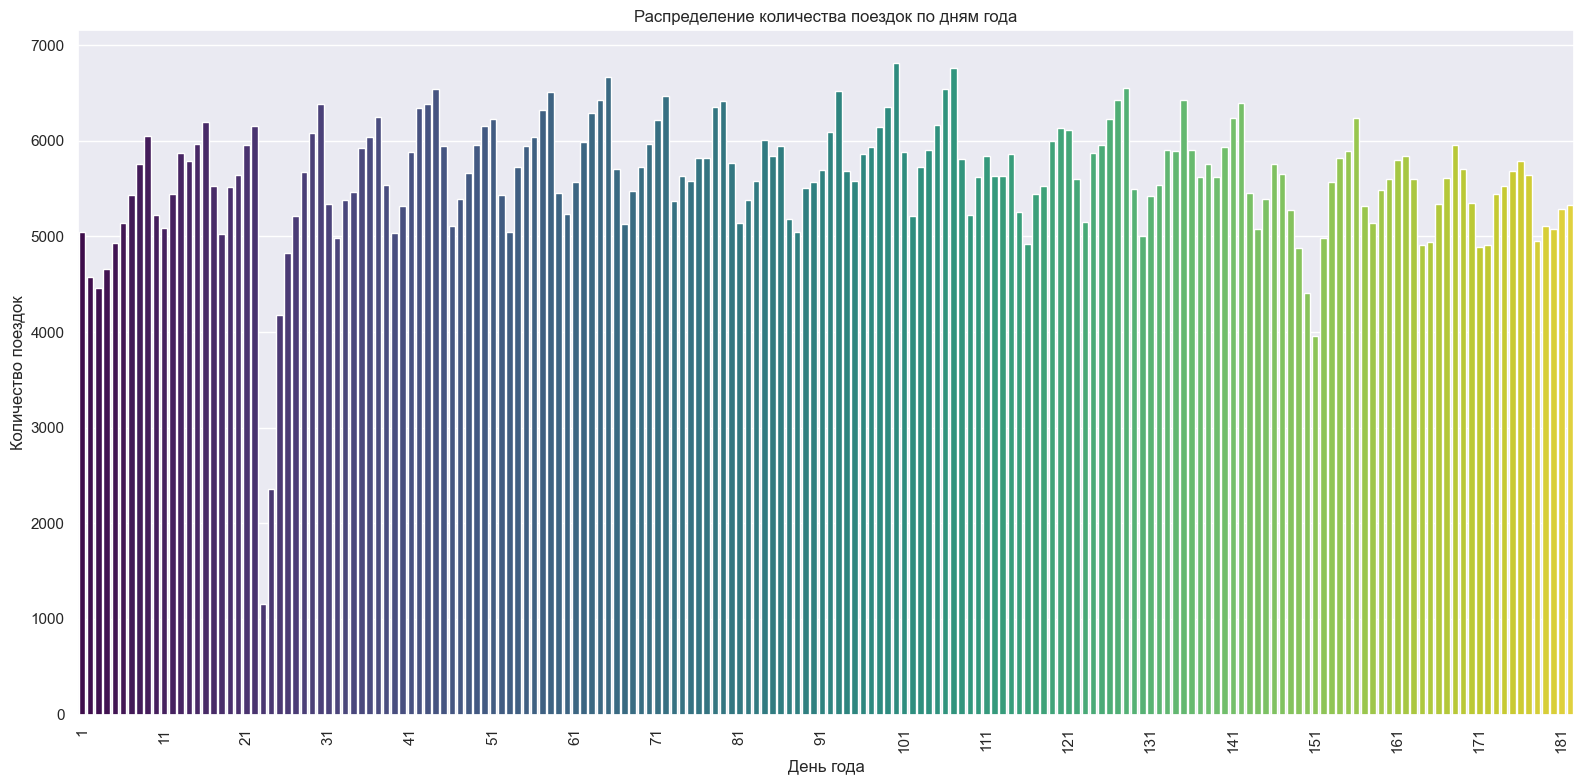

     day_of_year  trip_count
22            23        1162
23            24        2362
150          151        3955
24            25        4176
149          150        4408
2              3        4460
1              2        4581


In [313]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_data['day_of_year'] = train_data['pickup_datetime'].dt.dayofyear

plt.figure(figsize=(16, 8))
sns.countplot(data=train_data, x='day_of_year', palette='viridis')

plt.xlabel('День года')
plt.ylabel('Количество поездок')
plt.title('Распределение количества поездок по дням года')
plt.xticks(rotation=90)

plt.gca().set_xticks(plt.gca().get_xticks()[::10])
plt.tight_layout()
plt.show()

trips = train_data.groupby('day_of_year').size().reset_index(name='trip_count')
smallest = trips.nsmallest(7, 'trip_count')
print(smallest.head(10))

#22 января 2016 года - снежная буря, запрет автомобильного движения

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

<Figure size 1200x600 with 0 Axes>

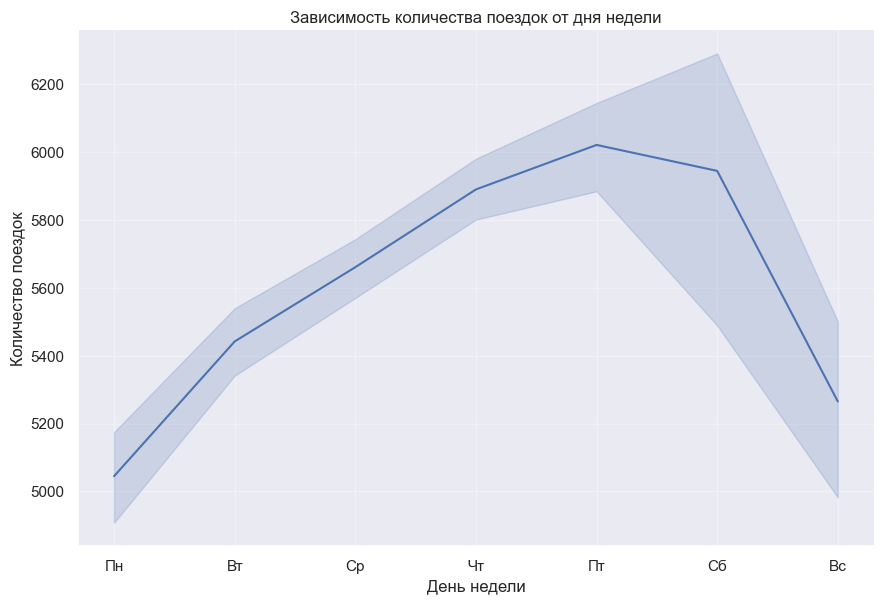

<Figure size 1400x600 with 0 Axes>

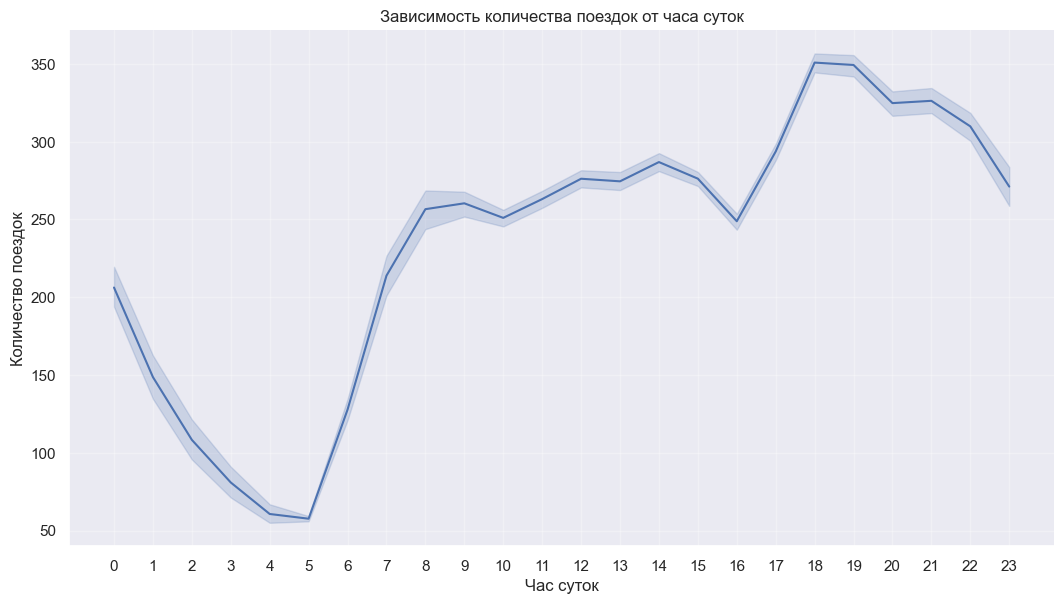

In [314]:
train_data['day_of_week'] = train_data['pickup_datetime'].dt.dayofweek  # 0-6 (пн-вс)
train_data['hour'] = train_data['pickup_datetime'].dt.hour  # 0-23
train_data['date'] = train_data['pickup_datetime'].dt.date  # дата без времени

daily_counts = train_data.groupby(['date', 'day_of_week']).size().reset_index(name='trip_count')
hourly_counts = train_data.groupby(['date', 'hour']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
sns.relplot(
    data=daily_counts,
    x='day_of_week', 
    y='trip_count',
    kind='line',
    height=6,
    aspect=1.5
)
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.title('Зависимость количества поездок от дня недели')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], 
           labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 6))
sns.relplot(
    data=hourly_counts,
    x='hour', 
    y='trip_count',
    kind='line',
    height=6,
    aspect=1.8
)
plt.xlabel('Час суток')
plt.ylabel('Количество поездок')
plt.title('Зависимость количества поездок от часа суток')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

**Задание 3.**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

<Figure size 1200x600 with 0 Axes>

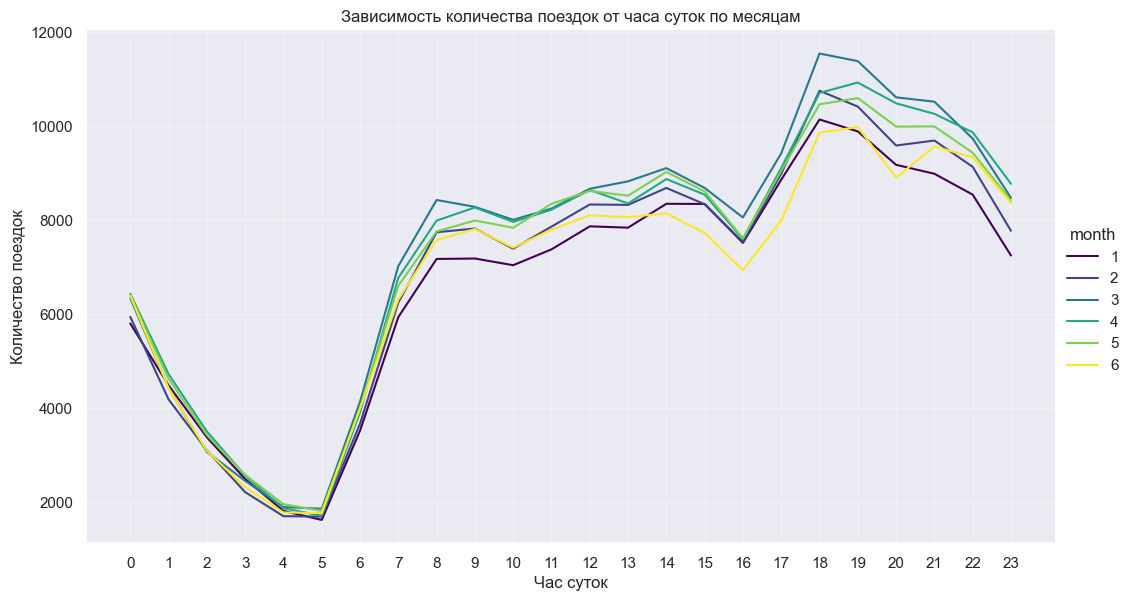

<Figure size 1200x600 with 0 Axes>

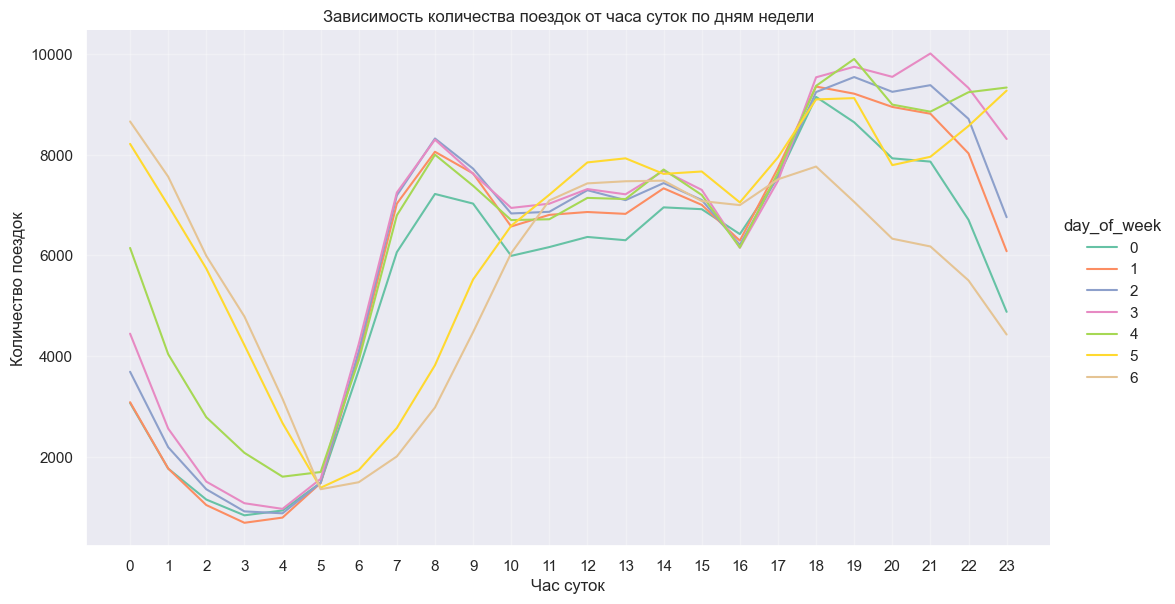

In [315]:
train_data['month'] = train_data['pickup_datetime'].dt.month
monthly_hourly = train_data.groupby(['month', 'hour']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
sns.relplot(
    data=monthly_hourly,
    x='hour',
    y='trip_count', 
    hue='month',
    kind='line',
    height=6,
    aspect=1.8,
    palette='viridis'
)
plt.xlabel('Час суток')
plt.ylabel('Количество поездок')
plt.title('Зависимость количества поездок от часа суток по месяцам')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

# Создаем данные: количество поездок по часам и дням недели
weekday_hourly = train_data.groupby(['day_of_week', 'hour']).size().reset_index(name='trip_count')

plt.figure(figsize=(12, 6))
sns.relplot(
    data=weekday_hourly,
    x='hour',
    y='trip_count',
    hue='day_of_week',     # Разные цвета для разных дней недели
    kind='line', 
    height=6,
    aspect=1.8,
    palette='Set2'         # Другая цветовая палитра
)
plt.xlabel('Час суток')
plt.ylabel('Количество поездок')
plt.title('Зависимость количества поездок от часа суток по дням недели')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4.**. По *обучающей выборке* нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

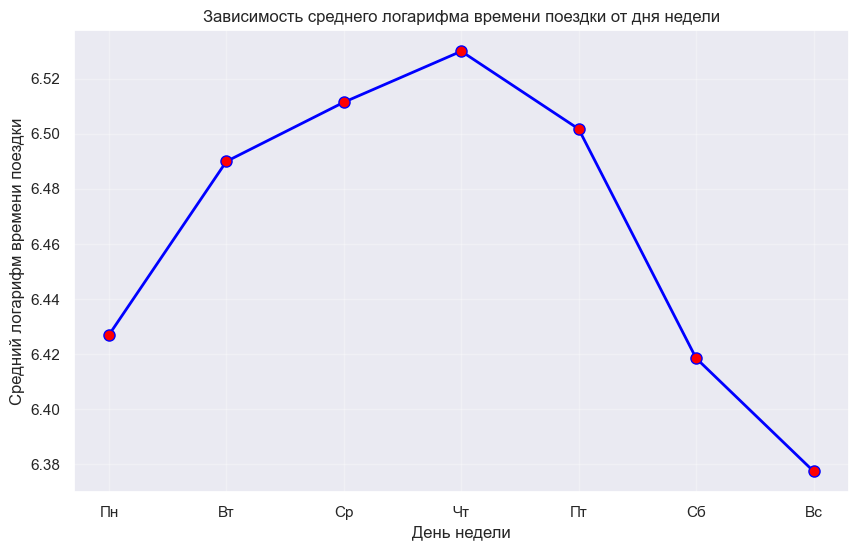

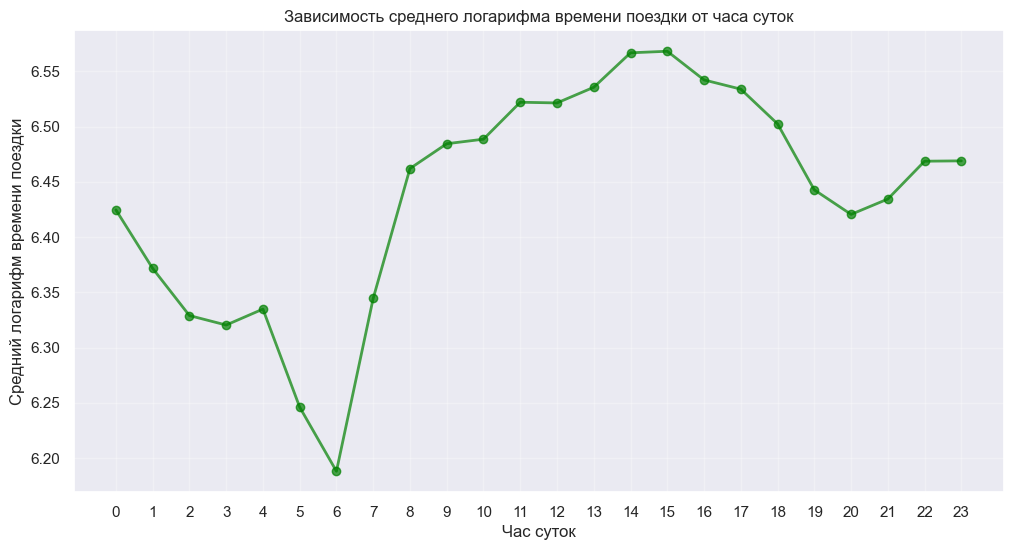

In [316]:
train_data['log_trip_duration'] = np.log1p(train_data['trip_duration'])
weekday_log_duration = train_data.groupby('day_of_week')['log_trip_duration'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(weekday_log_duration['day_of_week'], weekday_log_duration['log_trip_duration'], 
         'o-', linewidth=2, markersize=8, color='blue', markerfacecolor='red')
plt.xlabel('День недели')
plt.ylabel('Средний логарифм времени поездки')
plt.title('Зависимость среднего логарифма времени поездки от дня недели')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], 
           labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True, alpha=0.3)
plt.show()


hourly_log_duration = train_data.groupby('hour')['log_trip_duration'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_log_duration['hour'], hourly_log_duration['log_trip_duration'], 
         'o-', linewidth=2, markersize=6, color='green', alpha=0.7)
plt.xlabel('Час суток')
plt.ylabel('Средний логарифм времени поездки')
plt.title('Зависимость среднего логарифма времени поездки от часа суток')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [317]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def isSnowPeriod(day):
    return day >= 21 and day <= 23
def isSecondPeriod(day):
    return day >= 150 and day <= 152

train_data['day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data['month'] = train_data['pickup_datetime'].dt.month
train_data['hour'] = train_data['pickup_datetime'].dt.hour
train_data['day_of_year'] = train_data['pickup_datetime'].dt.dayofyear

train_data['is_snow_period'] = train_data['day_of_year'].apply(isSnowPeriod).astype(int)
train_data['is_second_period'] = train_data['day_of_year'].apply(isSecondPeriod).astype(int)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5.**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

RMSE на обучающей выборке (логарифмы): 0.3056
RMSE на тестовой выборке (логарифмы): 0.3046
RMSE на тестовой выборке (секунды): 360.1761
Средняя длительность поездки: 1110.8 сек
Стандартное отклонение: 359.3 сек
RMSE / MEAN = 0.32425771089026545


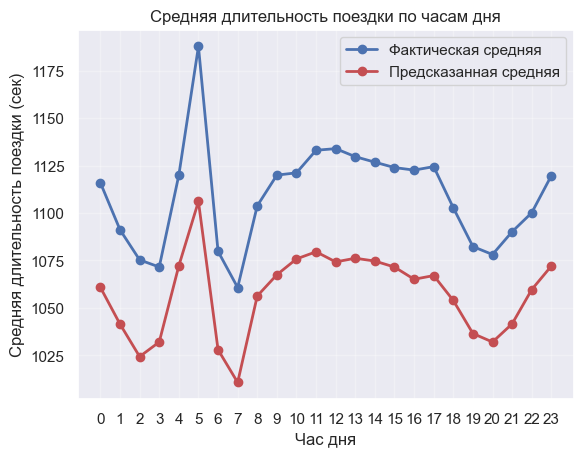

In [318]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

test_data['day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
test_data['month'] = test_data['pickup_datetime'].dt.month
test_data['hour'] = test_data['pickup_datetime'].dt.hour
test_data['day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data['is_snow_period'] = test_data['day_of_year'].apply(isSnowPeriod).astype(int)
test_data['is_second_period'] = test_data['day_of_year'].apply(isSecondPeriod).astype(int)

lower_bound = train_data['trip_duration'].quantile(0.5)
upper_bound = train_data['trip_duration'].quantile(0.95)

train_data_clean = train_data[
    (train_data['trip_duration'] >= lower_bound) & 
    (train_data['trip_duration'] <= upper_bound)
].copy()

test_data_clean = test_data[
    (test_data['trip_duration'] >= lower_bound) & 
    (test_data['trip_duration'] <= upper_bound)
].copy()

categorical_features = ['day_of_week', 'month', 'hour', 'is_snow_period', 'is_second_period']
numerical_features = ['day_of_year']

X_train = train_data_clean[categorical_features + numerical_features]
y_train = np.log1p(train_data_clean['trip_duration'])  # Логарифм таргета

X_test = test_data_clean[categorical_features + numerical_features]
y_test = np.log1p(test_data_clean['trip_duration'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

train_rmse_log = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"RMSE на обучающей выборке (логарифмы): {train_rmse_log:.4f}")
print(f"RMSE на тестовой выборке (логарифмы): {test_rmse_log:.4f}")

y_pred_test_original = np.expm1(y_pred_test)
y_test_original = np.expm1(y_test)

test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
print(f"RMSE на тестовой выборке (секунды): {test_rmse_original:.4f}")

print(f"Средняя длительность поездки: {train_data_clean['trip_duration'].mean():.1f} сек")
print(f"Стандартное отклонение: {train_data_clean['trip_duration'].std():.1f} сек")

print(f'RMSE / MEAN = {test_rmse_original / train_data_clean['trip_duration'].mean()}')

hours = X_test['hour']
actual_by_hour = pd.DataFrame({'hour': hours, 'duration': y_test_original})
predicted_by_hour = pd.DataFrame({'hour': hours, 'duration': y_pred_test_original})

actual_means = actual_by_hour.groupby('hour')['duration'].mean()
predicted_means = predicted_by_hour.groupby('hour')['duration'].mean()

plt.plot(actual_means.index, actual_means.values, 'bo-', label='Фактическая средняя', linewidth=2)
plt.plot(predicted_means.index, predicted_means.values, 'ro-', label='Предсказанная средняя', linewidth=2)
plt.xlabel('Час дня')
plt.ylabel('Средняя длительность поездки (сек)')
plt.title('Средняя длительность поездки по часам дня')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.show()

## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Подготовлена функция, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [319]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

In [320]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

In [321]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[np.float64(40.750940982818605), np.float64(-73.97234815216065)], controls=(ZoomControl(options=['p…

In [322]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

Map(center=[np.float64(40.75315148925781), np.float64(-73.97309636688233)], controls=(ZoomControl(options=['po…

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6.**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [323]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

train_data['haversine'] = haversine(
    train_data['pickup_longitude'], train_data['pickup_latitude'],
    train_data['dropoff_longitude'], train_data['dropoff_latitude']
)

test_data['haversine'] = haversine(
    test_data['pickup_longitude'], test_data['pickup_latitude'],
    test_data['dropoff_longitude'], test_data['dropoff_latitude']
)

print(train_data['haversine'].head(5))

0    1.498521
1    1.805507
2    6.385098
3    1.485498
4    1.188588
Name: haversine, dtype: float64


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [324]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_data['log_haversine'] = np.log1p(train_data['haversine'])
test_data['log_haversine'] = np.log1p(test_data['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [325]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import matplotlib.pyplot as plt

train_data['log_trip_duration'] = np.log1p(train_data['trip_duration'])
test_data['log_trip_duration'] = np.log1p(test_data['trip_duration'])

corr_original = train_data['haversine'].corr(train_data['trip_duration'])
corr_log_distance = train_data['log_haversine'].corr(train_data['trip_duration'])
corr_log_both = train_data['log_haversine'].corr(train_data['log_trip_duration'])

print("Корреляции:")
print(f"Расстояние vs Время: {corr_original:.4f}")
print(f"log(Расстояние) vs Время: {corr_log_distance:.4f}")
print(f"log(Расстояние) vs log(Время): {corr_log_both:.4f}")


Корреляции:
Расстояние vs Время: 0.0831
log(Расстояние) vs Время: 0.0917
log(Расстояние) vs log(Время): 0.7498


**Задание 7.** Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

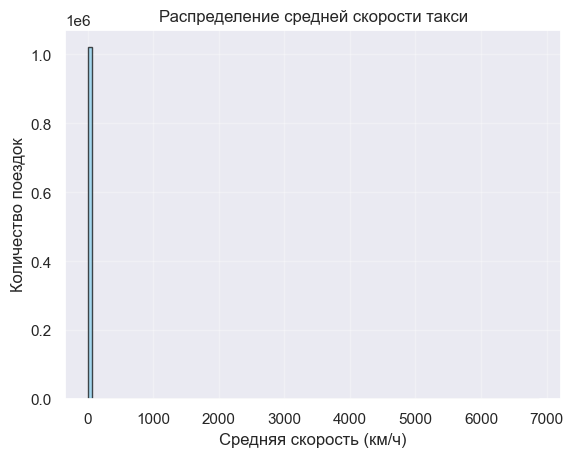

In [326]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_data['speed_kmh'] = train_data['haversine'] / (train_data['trip_duration'] / 3600)
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

plt.hist(train_data['speed_kmh'], bins=100, alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Количество поездок')
plt.title('Распределение средней скорости такси')
plt.grid(True, alpha=0.3)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

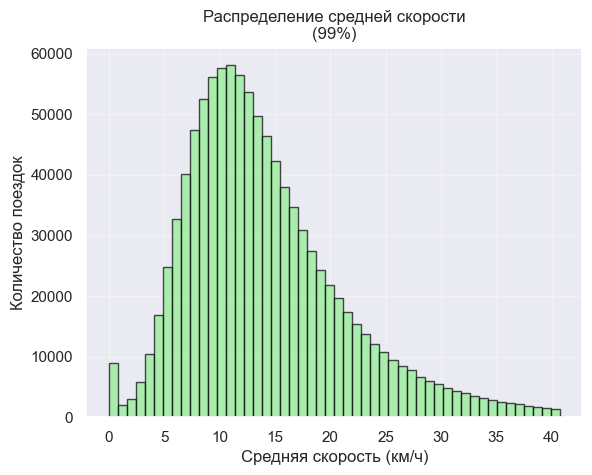

In [327]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
upper_quantile = train_data['speed_kmh'].quantile(0.99)
reasonable_speeds = train_data['speed_kmh'][
    (train_data['speed_kmh'] <= upper_quantile)
]
plt.hist(reasonable_speeds, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
plt.xlabel('Средняя скорость (км/ч)')
plt.ylabel('Количество поездок')
plt.title('Распределение средней скорости\n(99%)')
plt.grid(True, alpha=0.3)
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

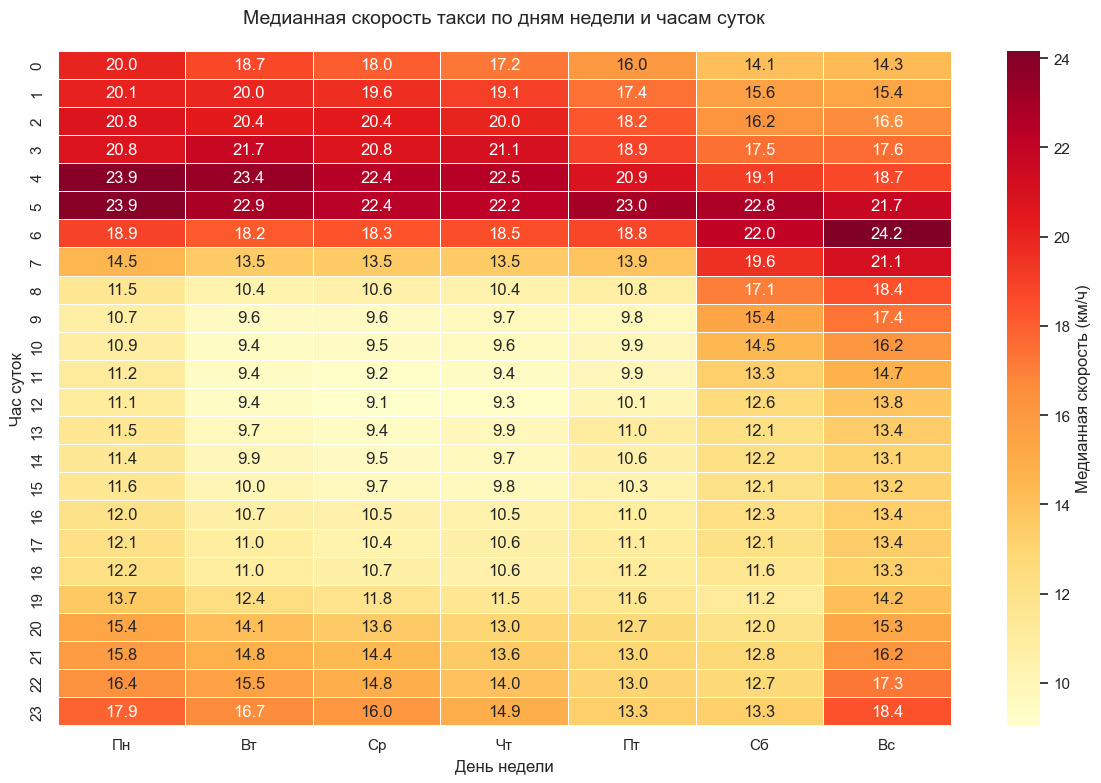

In [328]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# Создаем таблицу с медианой скоростей для каждой пары (день недели, час)
speed_pivot = train_data.pivot_table(
    values='speed_kmh',
    index='hour',
    columns='day_of_week',
    aggfunc='median'
)

# Переименовываем для читаемости
days_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
speed_pivot.columns = days_names

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.figure(figsize=(12, 8))
sns.heatmap(
    speed_pivot, 
    annot=True,           # Показывать значения в ячейках
    fmt='.1f',           # Формат чисел: одна десятичная
    cmap='YlOrRd',       # Цветовая схема: желтый-оранжевый-красный
    linewidths=0.5,      # Тонкие линии между ячейками
    cbar_kws={'label': 'Медианная скорость (км/ч)'}  # Подпись цветовой шкалы
)

plt.title('Медианная скорость такси по дням недели и часам суток', fontsize=14, pad=20)
plt.xlabel('День недели')
plt.ylabel('Час суток')
plt.tight_layout()
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [329]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_data = train_data.drop('speed_kmh', axis=1)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [330]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_data['is_jam_time'] = (
    (train_data['hour'] >= 9) &
    (train_data['hour'] <= 15)
).astype(int)

train_data['is_night'] = (
    (train_data['hour'] >= 0) & 
    (train_data['hour'] <= 6)
).astype(int)


test_data['is_jam_time'] = (
    (test_data['hour'] >= 9) &
    (test_data['hour'] <= 15)
).astype(int)

test_data['is_night'] = (
    (test_data['hour'] >= 0) & 
    (test_data['hour'] <= 6)
).astype(int)

**Задание 8.** Как уже было замечено выше, на карте выделяются две точки - аэропорты La Guardia и John F Kennedy. Для каждого из аэропортов добавьте в выборки два признака: началась ли поездка из этого аэропорта и закончилась ли поездка в этом аэропорте.

In [331]:
airports = {
    'JFK': (40.6413, -73.7781),    # John F Kennedy
    'LGA': (40.7769, -73.8740)     # La Guardia
}

# Радиус для определения "попадания" в аэропорт (в км)
AIRPORT_RADIUS_KM = 2.0

def is_near_airport(lat, lon, airport_coords, radius_km=AIRPORT_RADIUS_KM):
    """
    Проверяет, находится ли точка в радиусе от аэропорта
    """
    distance = haversine(lon, lat, airport_coords[1], airport_coords[0])
    return (distance <= radius_km).astype(int)

train_data['pickup_near_JFK'] = is_near_airport(
    train_data['pickup_latitude'], 
    train_data['pickup_longitude'], 
    airports['JFK']
)
train_data['dropoff_near_JFK'] = is_near_airport(
    train_data['dropoff_latitude'], 
    train_data['dropoff_longitude'], 
    airports['JFK']
)

test_data['pickup_near_JFK'] = is_near_airport(
    test_data['pickup_latitude'], 
    test_data['pickup_longitude'], 
    airports['JFK']
)
test_data['dropoff_near_JFK'] = is_near_airport(
    test_data['dropoff_latitude'], 
    test_data['dropoff_longitude'], 
    airports['JFK']
)



train_data['pickup_near_LGA'] = is_near_airport(
    train_data['pickup_latitude'], 
    train_data['pickup_longitude'], 
    airports['LGA']
)
train_data['dropoff_near_LGA'] = is_near_airport(
    train_data['dropoff_latitude'], 
    train_data['dropoff_longitude'], 
    airports['LGA']
)

test_data['pickup_near_LGA'] = is_near_airport(
    test_data['pickup_latitude'], 
    test_data['pickup_longitude'], 
    airports['LGA']
)
test_data['dropoff_near_LGA'] = is_near_airport(
    test_data['dropoff_latitude'], 
    test_data['dropoff_longitude'], 
    airports['LGA']
)



Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

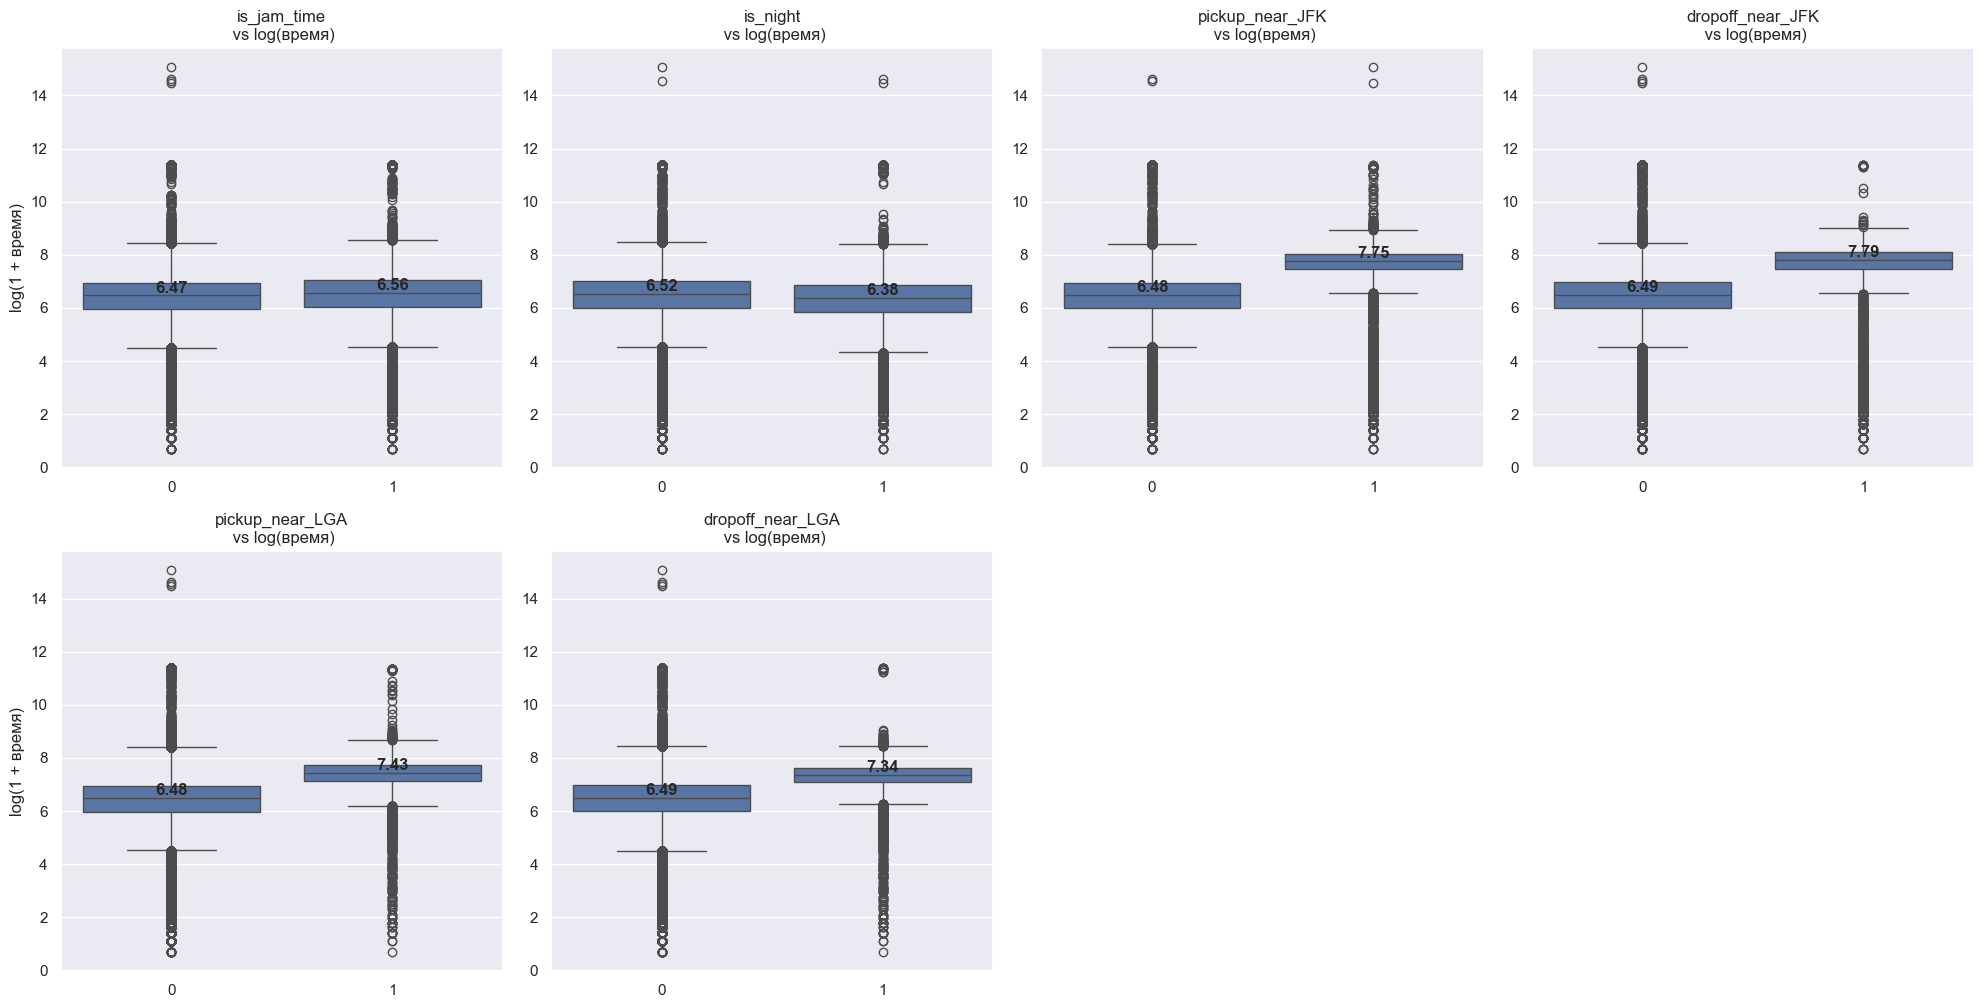

In [332]:
train_data['log_trip_duration'] = np.log1p(train_data['trip_duration'])
test_data['log_trip_duration'] = np.log1p(test_data['trip_duration'])

existing_features = [
    'is_jam_time',
    'is_night',
    'pickup_near_JFK',
    'dropoff_near_JFK',
    'pickup_near_LGA', 
    'dropoff_near_LGA',
]
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

for i, feature in enumerate(existing_features):
    if i < len(axes):
        # Простая версия без палитры
        sns.boxplot(
            data=train_data, 
            x=feature, 
            y='log_trip_duration', 
            ax=axes[i]
        )
        axes[i].set_title(f'{feature}\n vs log(время)')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('log(1 + время)' if i % 4 == 0 else '')
        
        # Добавляем аннотации с медианами
        medians = train_data.groupby(feature)['log_trip_duration'].median()
        for j, median in enumerate(medians):
            axes[i].text(j, median, f'{median:.2f}', 
                        ha='center', va='bottom', fontweight='bold')

# Убираем лишние subplots
for i in range(len(existing_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9.** Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [333]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_rows=4, num_cols=3,
                 lu_lat=40.766086, lu_lon=-74.020151,
                 height_deg=0.07, width_deg=0.05):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.lu_lat = lu_lat
        self.lu_lon = lu_lon
        self.height_deg = height_deg
        self.width_deg = width_deg
        self.min_lat = None
        self.max_lat = None
        self.min_lon = None
        self.max_lon = None
        self.cell_height = None
        self.cell_width = None

    def fit(self, X, y=None):
        self.min_lat = self.lu_lat - self.height_deg
        self.max_lat = self.lu_lat
        self.min_lon = self.lu_lon
        self.max_lon = self.lu_lon + self.width_deg

        self.cell_height = (self.max_lat - self.min_lat) / self.num_rows
        self.cell_width = (self.max_lon - self.min_lon) / self.num_cols
        return self

    def transform(self, X):
        assert self.cell_height is not None, "Вызовите fit() перед transform()"
        
        pickup_lat = X.iloc[:, 0].values
        pickup_lon = X.iloc[:, 1].values
        dropoff_lat = X.iloc[:, 2].values
        dropoff_lon = X.iloc[:, 3].values

        def get_cell_vectorized(lats, lons):
            outside = (
                (lats < self.min_lat) | (lats > self.max_lat) |
                (lons < self.min_lon) | (lons > self.max_lon)
            )
            
            rows = ((self.max_lat - lats) // self.cell_height).astype(int)
            cols = ((lons - self.min_lon) // self.cell_width).astype(int)
            
            rows = np.clip(rows, 0, self.num_rows - 1)
            cols = np.clip(cols, 0, self.num_cols - 1)
            
            cell_indices = rows * self.num_cols + cols
            cell_indices[outside] = -1
            return cell_indices

        start_cells = get_cell_vectorized(pickup_lat, pickup_lon)
        end_cells = get_cell_vectorized(dropoff_lat, dropoff_lon)

        return np.column_stack((start_cells, end_cells))

**Задание 10.** Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, численные признаки отмасштабируйте.

In [334]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge

numerical_features = ['day_of_year', 'haversine', 'log_haversine']
categorical_features = ['vendor_id', 'store_and_fwd_flag', 'day_of_week', 'is_snow_period', 'is_second_period', 
                       'is_jam_time', 'is_night', 'pickup_near_JFK', 'dropoff_near_JFK', 
                       'pickup_near_LGA', 'dropoff_near_LGA']
coord_features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

preprocessor = ColumnTransformer(
    transformers=[
        ('coords', MapGridTransformer(num_rows=4, num_cols=3), coord_features),
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# 5. Обучаем модель
X_train = train_data.drop('trip_duration', axis=1)
y_train = train_data['trip_duration']

pipeline.fit(X_train, y_train)

# 6. Предсказание на тестовых данных
X_test = test_data.drop('trip_duration', axis=1)
y_test = test_data['trip_duration']

y_pred = pipeline.predict(X_test)

# 7. Оценка качества
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# 8. Сравнение нескольких предсказаний
print("\n=== СРАВНЕНИЕ ПРЕДСКАЗАНИЙ ===")
comparison = pd.DataFrame({
    'Actual': y_test.head(10).values,
    'Predicted': y_pred[:10],
    'Error': y_test.head(10).values - y_pred[:10]
})
print(comparison)

=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===
R² Score: 0.0308
MAE: 422.43
RMSE: 3115.24

=== СРАВНЕНИЕ ПРЕДСКАЗАНИЙ ===
   Actual    Predicted       Error
0     558   717.715281 -159.715281
1     436   764.898804 -328.898804
2     302   411.174352 -109.174352
3     563   529.351590   33.648410
4     190   506.144229 -316.144229
5     614   632.786881  -18.786881
6    2738  2862.743222 -124.743222
7    1009  1519.800215 -510.800215
8    1615  1413.124445  201.875555
9     817   406.278586  410.721414


## Часть 3. Изучаем оставшиеся признаки

**Задание 11.** У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [335]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Количество уникальных значений
print(f"vendor_id: {data['vendor_id'].nunique()} уникальных значений")
print(f"passenger_count: {data['passenger_count'].nunique()} уникальных значений")
print(f"store_and_fwd_flag: {data['store_and_fwd_flag'].nunique()} уникальных значений")

vendor_id: 2 уникальных значений
passenger_count: 10 уникальных значений
store_and_fwd_flag: 2 уникальных значений


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

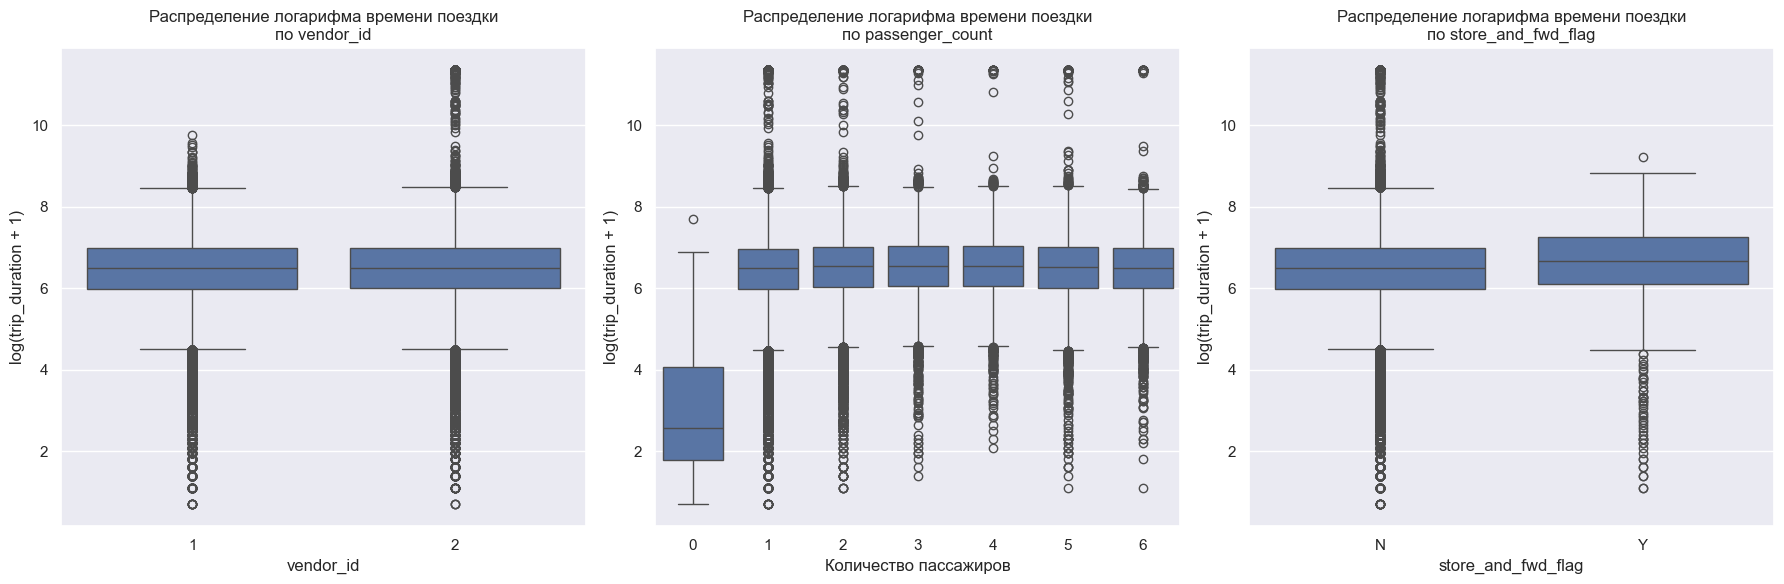

In [336]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Создаем фигуру с тремя subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Логарифм времени поездки
log_duration = np.log1p(test_data['trip_duration'])

# 1. vendor_id
sns.boxplot(x='vendor_id', y=log_duration, data=test_data, ax=axes[0])
axes[0].set_title('Распределение логарифма времени поездки\nпо vendor_id')
axes[0].set_xlabel('vendor_id')
axes[0].set_ylabel('log(trip_duration + 1)')

# 2. passenger_count
sns.boxplot(x='passenger_count', y=log_duration, data=test_data, ax=axes[1])
axes[1].set_title('Распределение логарифма времени поездки\nпо passenger_count')
axes[1].set_xlabel('Количество пассажиров')
axes[1].set_ylabel('log(trip_duration + 1)')

# 3. store_and_fwd_flag
sns.boxplot(x='store_and_fwd_flag', y=log_duration, data=test_data, ax=axes[2])
axes[2].set_title('Распределение логарифма времени поездки\nпо store_and_fwd_flag')
axes[2].set_xlabel('store_and_fwd_flag')
axes[2].set_ylabel('log(trip_duration + 1)')

plt.tight_layout()
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [337]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
train_data['vendor_id'] = train_data['vendor_id'].astype('category').cat.codes
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].astype('category').cat.codes
test_data['vendor_id'] = test_data['vendor_id'].astype('category').cat.codes
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].astype('category').cat.codes

print("Уникальные значения после преобразования:")
print(f"vendor_id: {sorted(train_data['vendor_id'].unique())}")
print(f"store_and_fwd_flag: {sorted(train_data['store_and_fwd_flag'].unique())}")

Уникальные значения после преобразования:
vendor_id: [np.int8(0), np.int8(1)]
store_and_fwd_flag: [np.int8(0), np.int8(1)]


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12.** Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [338]:
preprocessor = ColumnTransformer(
    transformers=[
        ('coords', MapGridTransformer(), coord_features),
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

X_train = train_data.drop('trip_duration', axis=1)
y_train = train_data['trip_duration']

pipeline.fit(X_train, y_train)

X_test = test_data.drop('trip_duration', axis=1)
y_test = test_data['trip_duration']

y_pred = pipeline.predict(X_test)

print("=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

print("\n=== СРАВНЕНИЕ ПРЕДСКАЗАНИЙ ===")
comparison = pd.DataFrame({
    'Actual': y_test.head(10).values,
    'Predicted': y_pred[:10],
    'Error': y_test.head(10).values - y_pred[:10]
})
print(comparison)

=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===
R² Score: 0.0308
MAE: 422.43
RMSE: 3115.24

=== СРАВНЕНИЕ ПРЕДСКАЗАНИЙ ===
   Actual    Predicted       Error
0     558   717.715281 -159.715281
1     436   764.898804 -328.898804
2     302   411.174352 -109.174352
3     563   529.351590   33.648410
4     190   506.144229 -316.144229
5     614   632.786881  -18.786881
6    2738  2862.743222 -124.743222
7    1009  1519.800215 -510.800215
8    1615  1413.124445  201.875555
9     817   406.278586  410.721414


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель

**Задание 13.** В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

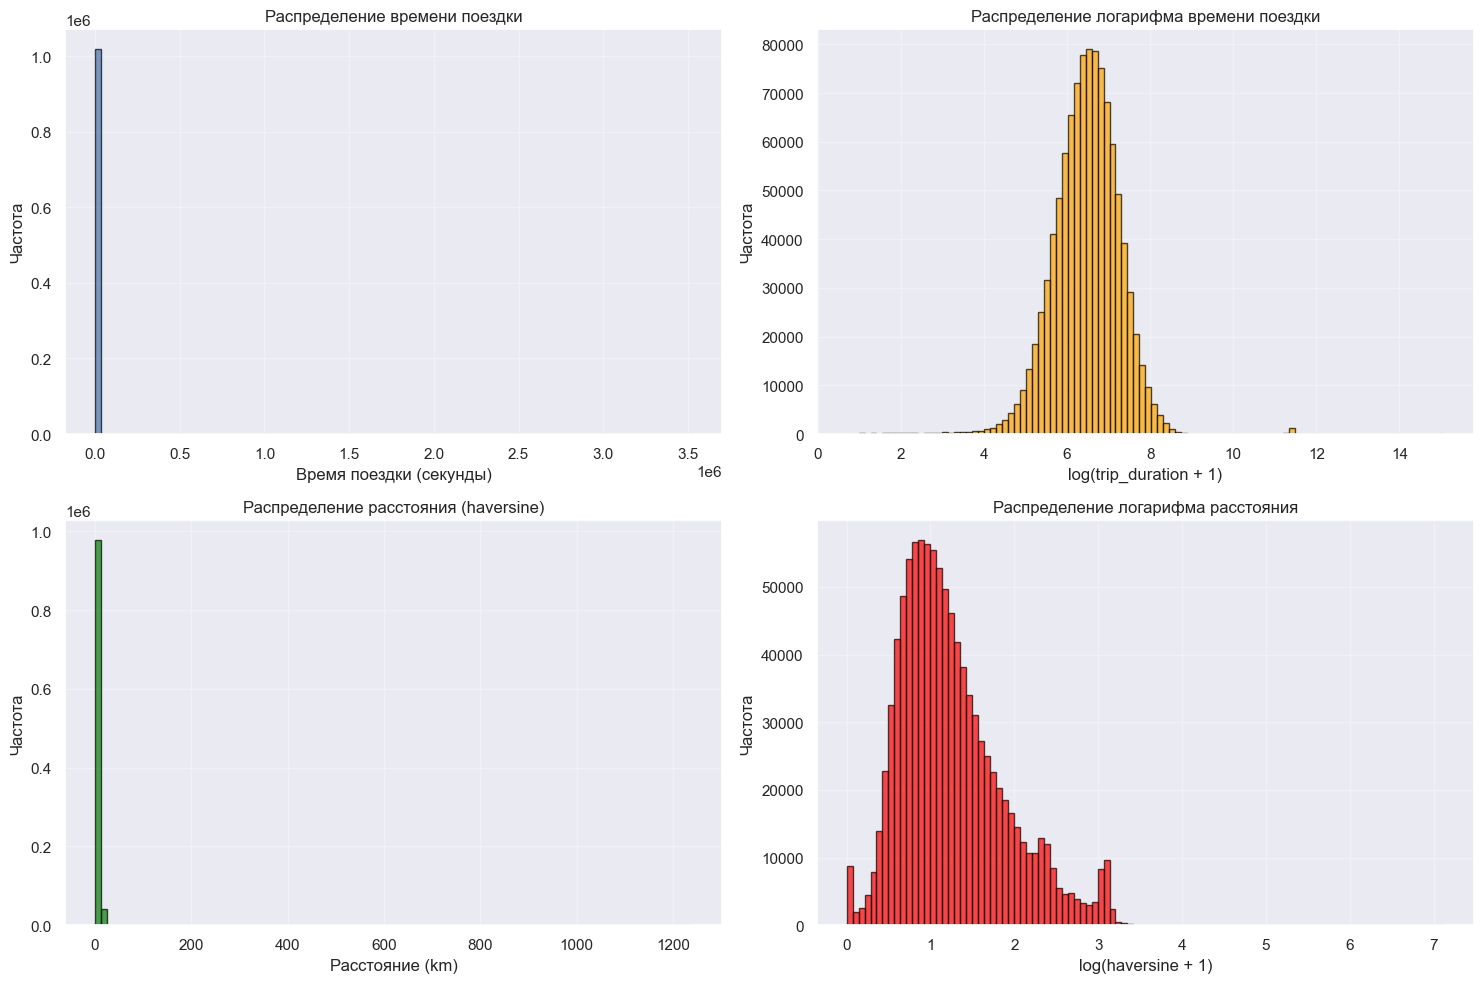

=== СТАТИСТИКА ДЛЯ ВЫЯВЛЕНИЯ ВЫБРОСОВ ===
Время поездки (trip_duration):
Min: 1
5%: 180.00
95%: 2104.00
99%: 3436.51
Max: 3526282

Расстояние (haversine):
Min: 0.0
5%: 0.5953
95%: 11.0057
99%: 20.7806
Max: 1240.9086766508526

Границы для фильтрации:
Время поездки: < 87.00 сек или > 3436.51 сек
Расстояние: > 20.7806 км

=== РЕЗУЛЬТАТЫ ФИЛЬТРАЦИИ ===
Исходный размер данных: 1021050
Размер после очистки: 993315
Удалено выбросов: 27735
Процент удаленных данных: 2.72%


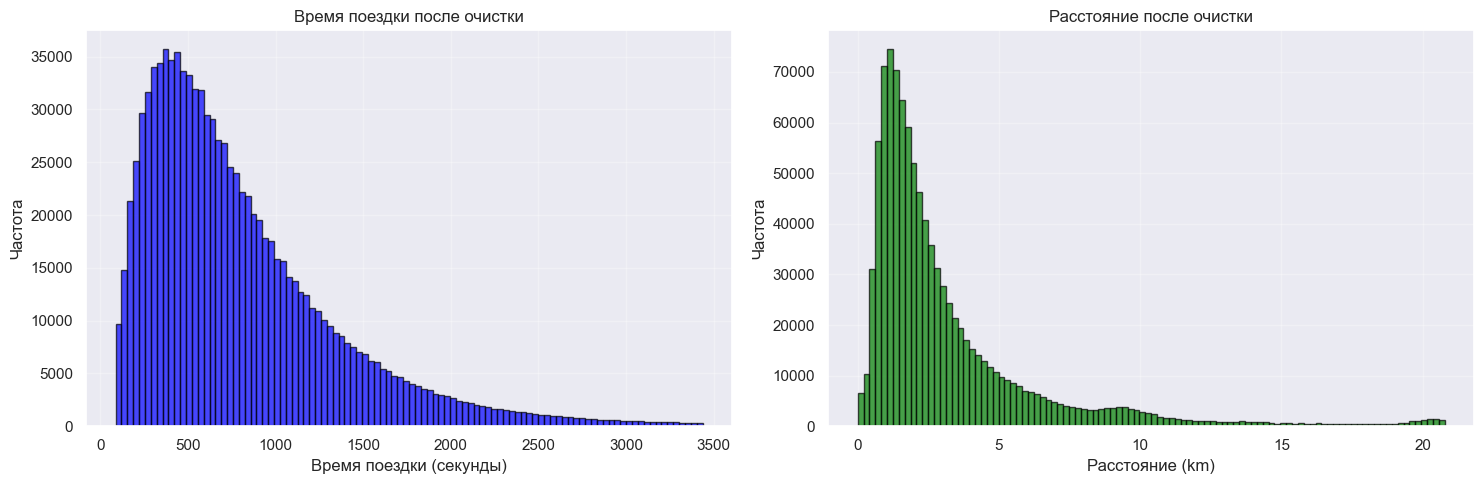

In [339]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import matplotlib.pyplot as plt
import numpy as np

# Создаем фигуру с гистограммами
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Гистограмма времени поездки
axes[0, 0].hist(train_data['trip_duration'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение времени поездки')
axes[0, 0].set_xlabel('Время поездки (секунды)')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма логарифма времени поездки (для лучшей визуализации)
axes[0, 1].hist(np.log1p(train_data['trip_duration']), bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Распределение логарифма времени поездки')
axes[0, 1].set_xlabel('log(trip_duration + 1)')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].grid(True, alpha=0.3)

# 3. Гистограмма расстояния (haversine)
axes[1, 0].hist(train_data['haversine'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('Распределение расстояния (haversine)')
axes[1, 0].set_xlabel('Расстояние (km)')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].grid(True, alpha=0.3)

# 4. Гистограмма логарифма расстояния
axes[1, 1].hist(np.log1p(train_data['haversine']), bins=100, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('Распределение логарифма расстояния')
axes[1, 1].set_xlabel('log(haversine + 1)')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ выбросов
print("=== СТАТИСТИКА ДЛЯ ВЫЯВЛЕНИЯ ВЫБРОСОВ ===")
print("Время поездки (trip_duration):")
print(f"Min: {train_data['trip_duration'].min()}")
print(f"5%: {train_data['trip_duration'].quantile(0.05):.2f}")
print(f"95%: {train_data['trip_duration'].quantile(0.95):.2f}")
print(f"99%: {train_data['trip_duration'].quantile(0.99):.2f}")
print(f"Max: {train_data['trip_duration'].max()}")

print("\nРасстояние (haversine):")
print(f"Min: {train_data['haversine'].min()}")
print(f"5%: {train_data['haversine'].quantile(0.05):.4f}")
print(f"95%: {train_data['haversine'].quantile(0.95):.4f}")
print(f"99%: {train_data['haversine'].quantile(0.99):.4f}")
print(f"Max: {train_data['haversine'].max()}")

# Определяем границы для выбросов
duration_low = train_data['trip_duration'].quantile(0.01)   # Нижний 1%
duration_high = train_data['trip_duration'].quantile(0.99)  # Верхний 1%
distance_high = train_data['haversine'].quantile(0.99)      # Верхний 1% расстояния

print(f"\nГраницы для фильтрации:")
print(f"Время поездки: < {duration_low:.2f} сек или > {duration_high:.2f} сек")
print(f"Расстояние: > {distance_high:.4f} км")

# Фильтрация выбросов
original_size = len(train_data)
df_clean = train_data[
    (train_data['trip_duration'] >= duration_low) & 
    (train_data['trip_duration'] <= duration_high) & 
    (train_data['haversine'] <= distance_high)
]

print(f"\n=== РЕЗУЛЬТАТЫ ФИЛЬТРАЦИИ ===")
print(f"Исходный размер данных: {original_size}")
print(f"Размер после очистки: {len(df_clean)}")
print(f"Удалено выбросов: {original_size - len(df_clean)}")
print(f"Процент удаленных данных: {(original_size - len(df_clean)) / original_size * 100:.2f}%")

# Визуализация после очистки
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_clean['trip_duration'], bins=100, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_title('Время поездки после очистки')
axes[0].set_xlabel('Время поездки (секунды)')
axes[0].set_ylabel('Частота')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df_clean['haversine'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Расстояние после очистки')
axes[1].set_xlabel('Расстояние (km)')
axes[1].set_ylabel('Частота')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

train_data = df_clean

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

=== ЧАСТОТЫ КАТЕГОРИЙ ДО ОБЪЕДИНЕНИЯ ===

vendor_id:
  1: 530626 (53.42%)
  0: 462689 (46.58%)

store_and_fwd_flag:
  0: 988038 (99.47%)
  1: 5277 (0.53%)

day_of_week:
  4: 152097 (15.31%)
  5: 151057 (15.21%)
  3: 148741 (14.97%)
  2: 143163 (14.41%)
  1: 137858 (13.88%)
  6: 133024 (13.39%)
  0: 127375 (12.82%)

is_snow_period:
  0: 980381 (98.70%)
  1: 12934 (1.30%)

is_second_period:
  0: 980321 (98.69%)
  1: 12994 (1.31%)

is_jam_time:
  0: 659239 (66.37%)
  1: 334076 (33.63%)

is_night:
  0: 854436 (86.02%)
  1: 138879 (13.98%)

pickup_near_JFK:
  0: 980286 (98.69%)
  1: 13029 (1.31%)

dropoff_near_JFK:
  0: 989470 (99.61%)
  1: 3845 (0.39%)

pickup_near_LGA:
  0: 968673 (97.52%)
  1: 24642 (2.48%)

dropoff_near_LGA:
  0: 980650 (98.72%)
  1: 12665 (1.28%)


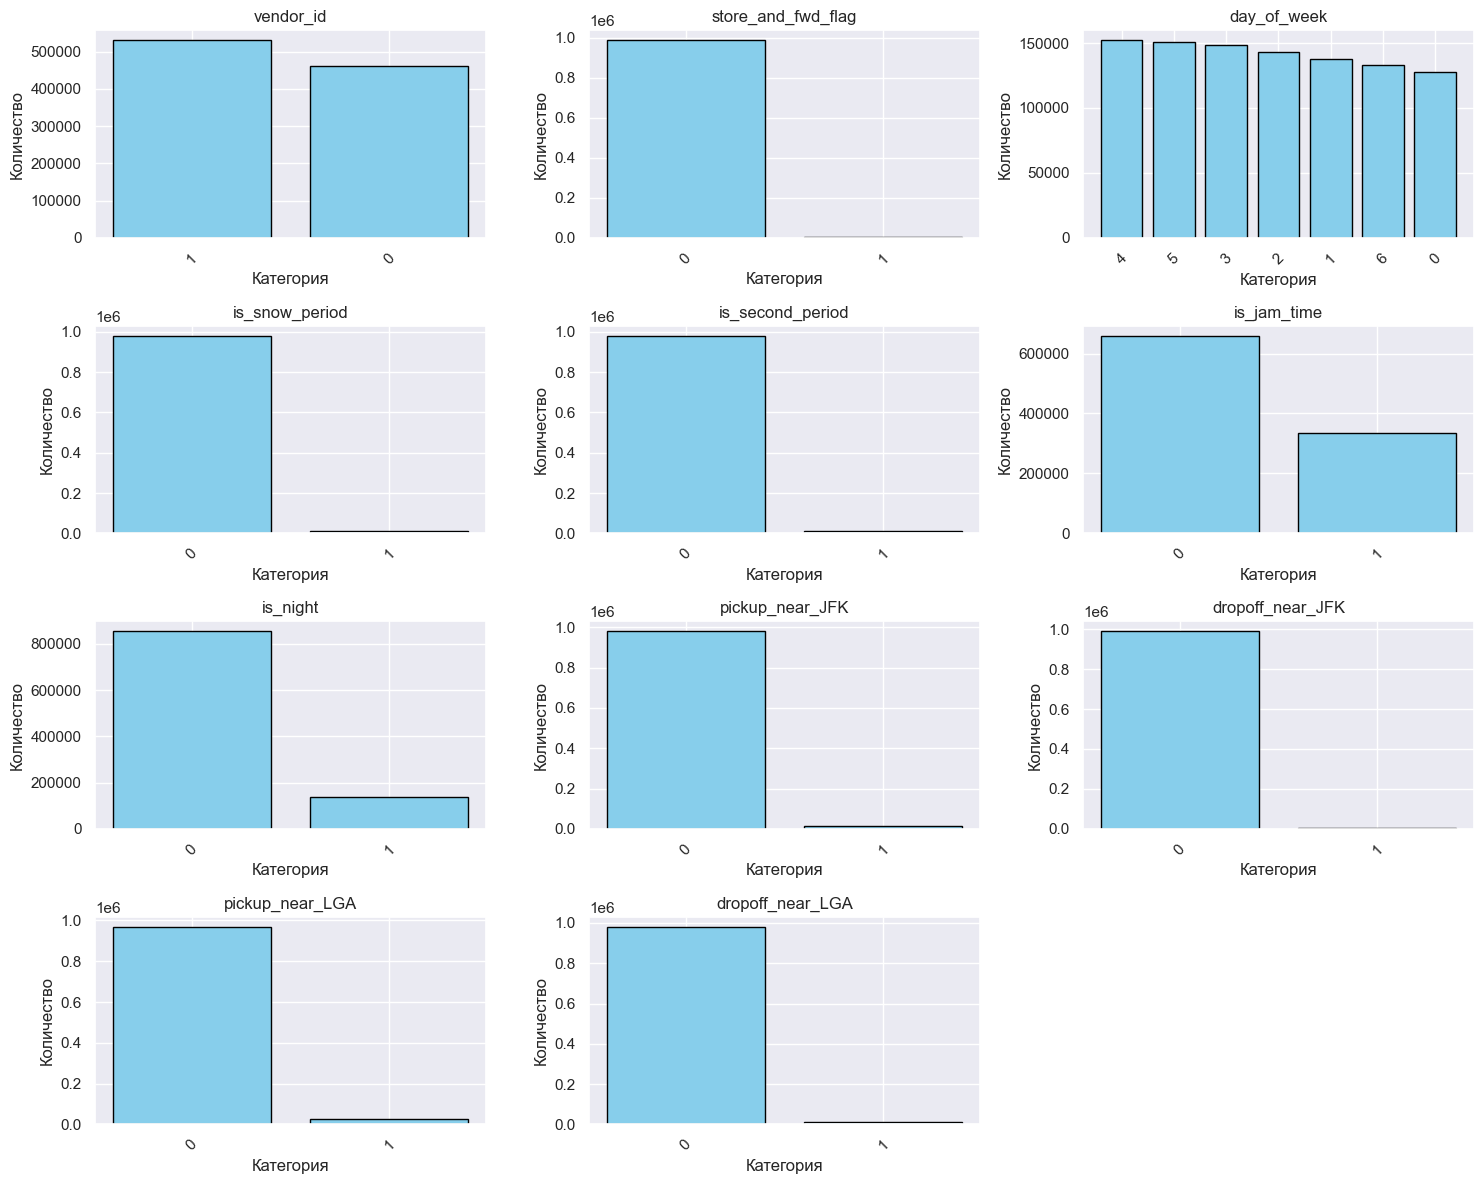


=== ОБЪЕДИНЕНИЕ РЕДКИХ КАТЕГОРИЙ (порог: 29799 записей) ===
vendor_id: редких категорий не найдено
store_and_fwd_flag: объединяем 1 редких категорий в 'OTHER'
day_of_week: редких категорий не найдено
is_snow_period: объединяем 1 редких категорий в 'OTHER'
is_second_period: объединяем 1 редких категорий в 'OTHER'
is_jam_time: редких категорий не найдено
is_night: редких категорий не найдено
pickup_near_JFK: объединяем 1 редких категорий в 'OTHER'
dropoff_near_JFK: объединяем 1 редких категорий в 'OTHER'
pickup_near_LGA: объединяем 1 редких категорий в 'OTHER'
dropoff_near_LGA: объединяем 1 редких категорий в 'OTHER'

=== ЧАСТОТЫ КАТЕГОРИЙ ПОСЛЕ ОБЪЕДИНЕНИЯ ===

vendor_id:
  1: 530626 (53.42%)
  0: 462689 (46.58%)

store_and_fwd_flag:
  0: 988038 (99.47%)
  OTHER: 5277 (0.53%)

day_of_week:
  4: 152097 (15.31%)
  5: 151057 (15.21%)
  3: 148741 (14.97%)
  2: 143163 (14.41%)
  1: 137858 (13.88%)
  6: 133024 (13.39%)
  0: 127375 (12.82%)

is_snow_period:
  0: 980381 (98.70%)
  OTHER: 12934

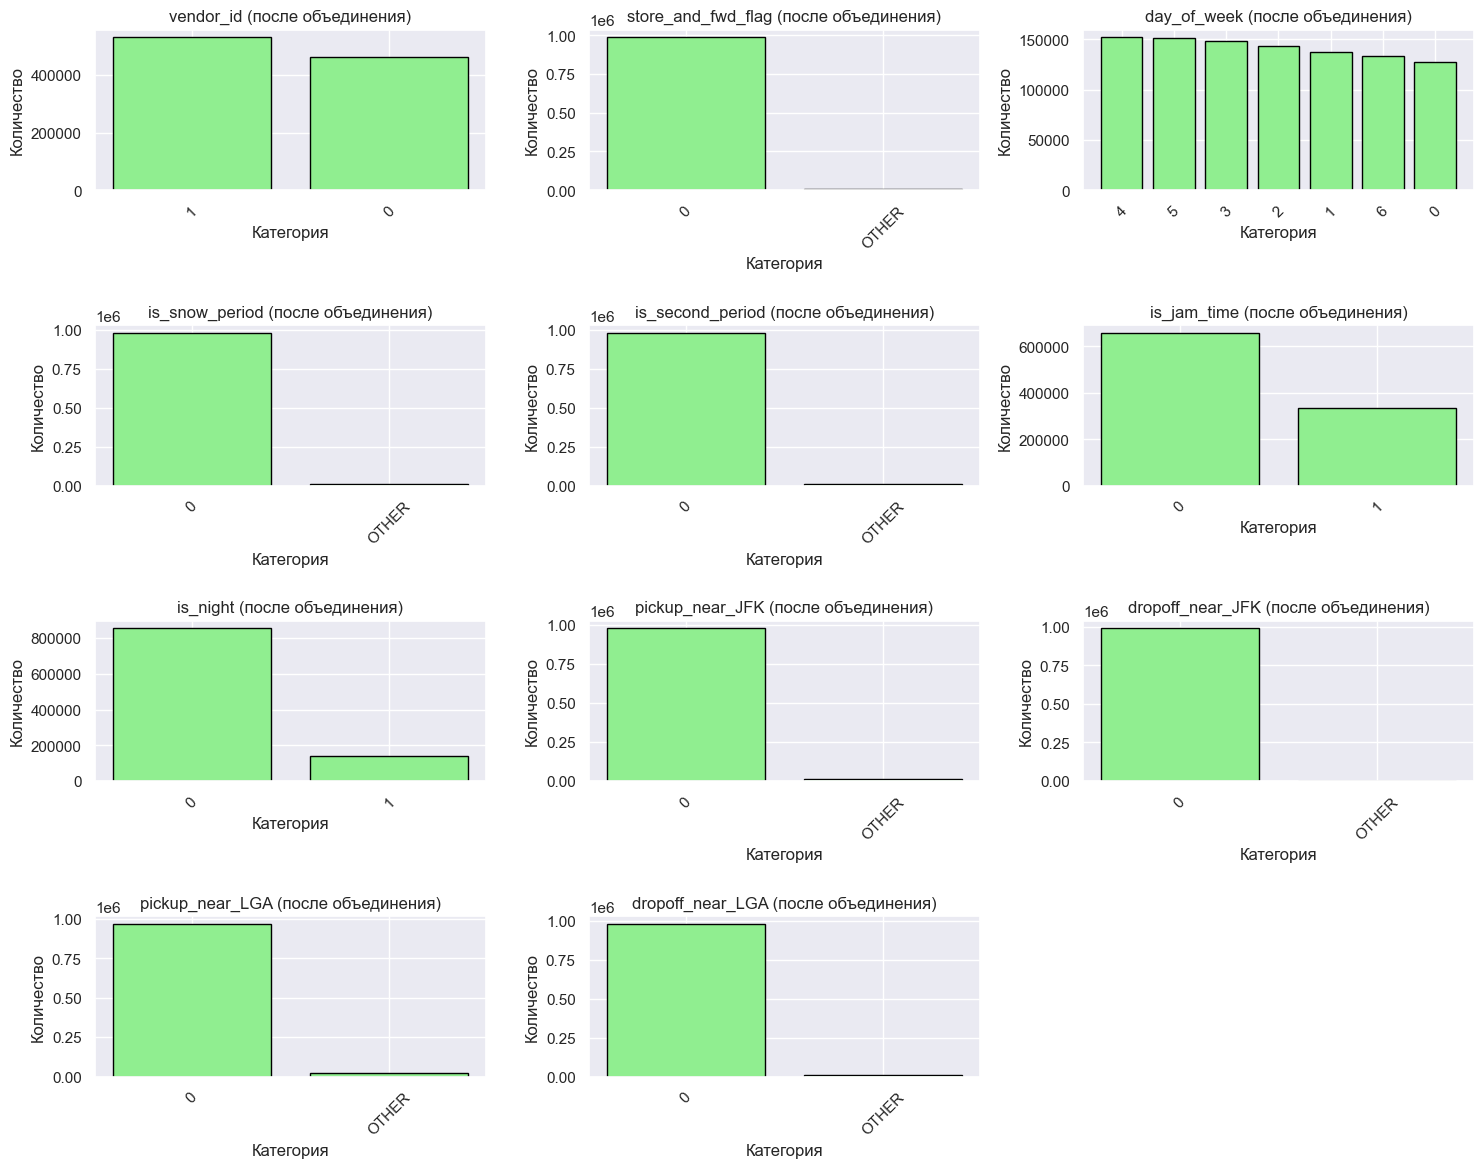

In [350]:
print("=== ЧАСТОТЫ КАТЕГОРИЙ ДО ОБЪЕДИНЕНИЯ ===")
for feature in categorical_features:
    value_counts = df_clean[feature].value_counts()
    print(f"\n{feature}:")
    for value, count in value_counts.items():
        percentage = count / len(df_clean) * 100
        print(f"  {value}: {count} ({percentage:.2f}%)")

# Визуализация распределения категорий
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        value_counts = df_clean[feature].value_counts()
        axes[i].bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{feature}')
        axes[i].set_xlabel('Категория')
        axes[i].set_ylabel('Количество')
        axes[i].tick_params(axis='x', rotation=45)
        
# Скрываем лишние subplots
for i in range(len(categorical_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Объединяем редкие категории
df_processed = df_clean.copy()

# Определяем порог для редких категорий (например, менее 1% данных)
rare_threshold = 0.03 * len(df_processed)

print(f"\n=== ОБЪЕДИНЕНИЕ РЕДКИХ КАТЕГОРИЙ (порог: {rare_threshold:.0f} записей) ===")

for feature in categorical_features:
    value_counts = df_processed[feature].value_counts()
    rare_categories = value_counts[value_counts < rare_threshold].index
    
    if len(rare_categories) > 0:
        print(f"{feature}: объединяем {len(rare_categories)} редких категорий в 'OTHER'")
        
        # Заменяем редкие категории на 'OTHER'
        df_processed[feature] = df_processed[feature].apply(
            lambda x: 'OTHER' if x in rare_categories else x
        )
    else:
        print(f"{feature}: редких категорий не найдено")

# Проверяем результаты после объединения
print(f"\n=== ЧАСТОТЫ КАТЕГОРИЙ ПОСЛЕ ОБЪЕДИНЕНИЯ ===")
for feature in categorical_features:
    value_counts = df_processed[feature].value_counts()
    print(f"\n{feature}:")
    for value, count in value_counts.items():
        percentage = count / len(df_processed) * 100
        print(f"  {value}: {count} ({percentage:.2f}%)")

# Визуализация после объединения
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        value_counts = df_processed[feature].value_counts()
        axes[i].bar(value_counts.index.astype(str), value_counts.values, color='lightgreen', edgecolor='black')
        axes[i].set_title(f'{feature} (после объединения)')
        axes[i].set_xlabel('Категория')
        axes[i].set_ylabel('Количество')
        axes[i].tick_params(axis='x', rotation=45)

# Скрываем лишние subplots
for i in range(len(categorical_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

train_data = df_processed
for feature in categorical_features:
    test_data[feature] = test_data[feature].astype(str)
    train_data[feature] = train_data[feature].astype(str)


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [352]:
X_train = train_data.drop('trip_duration', axis=1)
y_train = train_data['trip_duration']

pipeline.fit(X_train, y_train)

X_test = test_data.drop('trip_duration', axis=1)
y_test = test_data['trip_duration']

y_pred = pipeline.predict(X_test)

print("=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

print("\n=== СРАВНЕНИЕ ПРЕДСКАЗАНИЙ ===")
comparison = pd.DataFrame({
    'Actual': y_test.head(10).values,
    'Predicted': y_pred[:10],
    'Error': y_test.head(10).values - y_pred[:10]
})
print(comparison)

c:\Users\ivan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4, 7, 8, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===
R² Score: 0.0278
MAE: 368.62
RMSE: 3119.98

=== СРАВНЕНИЕ ПРЕДСКАЗАНИЙ ===
   Actual    Predicted       Error
0     558   540.817299   17.182701
1     436   678.868406 -242.868406
2     302   426.946050 -124.946050
3     563   480.230305   82.769695
4     190   444.783611 -254.783611
5     614   486.182511  127.817489
6    2738  2342.513213  395.486787
7    1009  1269.092337 -260.092337
8    1615  1348.285145  266.714855
9     817   446.930744  370.069256


**Задание 14.** После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [354]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Количество признаков ДО OneHot-кодирования
print("=== КОЛИЧЕСТВО ПРИЗНАКОВ ДО OneHot-кодирования ===")

# Числовые признаки
num_features_count = len(numerical_features)
print(f"Числовые признаки: {num_features_count}")

# Категориальные признаки (в исходном виде)
cat_features_count = len(categorical_features)
print(f"Категориальные признаки: {cat_features_count}")

# Всего признаков до кодирования
total_before = num_features_count + cat_features_count
print(f"ВСЕГО ПРИЗНАКОВ ДО КОДИРОВАНИЯ: {total_before}")

# Количество признаков ПОСЛЕ OneHot-кодирования
print("\n=== КОЛИЧЕСТВО ПРИЗНАКОВ ПОСЛЕ OneHot-кодирования ===")

# Применяем OneHotEncoder к тренировочным данным чтобы посчитать количество новых признаков
temp_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
temp_encoder.fit(train_data[categorical_features])

# Количество признаков после кодирования для каждой категориальной переменной
print("Количество признаков после OneHot-кодирования по каждой переменной:")
for i, feature in enumerate(categorical_features):
    feature_categories = temp_encoder.categories_[i]
    encoded_features_count = len(feature_categories) - 1  # -1 из-за drop='first'
    print(f"  {feature}: {len(feature_categories)} категорий → {encoded_features_count} признаков")

# Общее количество признаков после кодирования
total_encoded_cat_features = temp_encoder.transform(train_data[categorical_features]).shape[1]
total_after = num_features_count + total_encoded_cat_features

print(f"\nЧисловые признаки: {num_features_count}")
print(f"Категориальные признаки после кодирования: {total_encoded_cat_features}")
print(f"ВСЕГО ПРИЗНАКОВ ПОСЛЕ КОДИРОВАНИЯ: {total_after}")

# Статистика увеличения количества признаков
increase_ratio = total_after / total_before
print(f"\n=== СТАТИСТИКА ===")
print(f"Увеличение количества признаков в {increase_ratio:.1f} раз")
print(f"Добавлено {total_after - total_before} новых признаков")

# Визуализация
import matplotlib.pyplot as plt

categories = ['До кодирования', 'После кодирования']
values = [total_before, total_after]

=== КОЛИЧЕСТВО ПРИЗНАКОВ ДО OneHot-кодирования ===
Числовые признаки: 3
Категориальные признаки: 11
ВСЕГО ПРИЗНАКОВ ДО КОДИРОВАНИЯ: 14

=== КОЛИЧЕСТВО ПРИЗНАКОВ ПОСЛЕ OneHot-кодирования ===
Количество признаков после OneHot-кодирования по каждой переменной:
  vendor_id: 2 категорий → 1 признаков
  store_and_fwd_flag: 2 категорий → 1 признаков
  day_of_week: 7 категорий → 6 признаков
  is_snow_period: 2 категорий → 1 признаков
  is_second_period: 2 категорий → 1 признаков
  is_jam_time: 2 категорий → 1 признаков
  is_night: 2 категорий → 1 признаков
  pickup_near_JFK: 2 категорий → 1 признаков
  dropoff_near_JFK: 2 категорий → 1 признаков
  pickup_near_LGA: 2 категорий → 1 признаков
  dropoff_near_LGA: 2 категорий → 1 признаков

Числовые признаки: 3
Категориальные признаки после кодирования: 16
ВСЕГО ПРИЗНАКОВ ПОСЛЕ КОДИРОВАНИЯ: 19

=== СТАТИСТИКА ===
Увеличение количества признаков в 1.4 раз
Добавлено 5 новых признаков


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Стало ли лучше?

In [355]:
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

print("=== ОБУЧЕНИЕ LASSO-РЕГРЕССИИ ===")
lasso_pipeline.fit(X_train, y_train)

y_pred_lasso = lasso_pipeline.predict(X_test)

# Оценка качества Lasso-модели
print("\n=== ОЦЕНКА КАЧЕСТВА LASSO-РЕГРЕССИИ ===")
print(f"R² Score: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f}")

# Сравнение с Ridge-регрессией
print(f"\n=== СРАВНЕНИЕ RIDGE vs LASSO ===")
print("RIDGE-регрессия:")
print(f"  R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

print("\nLASSO-регрессия:")
print(f"  R² Score: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_lasso):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f}")

# Вывод
if r2_score(y_test, y_pred_lasso) > r2_score(y_test, y_pred):
    print("LASSO показала ЛУЧШИЕ результаты чем Ridge!")
elif r2_score(y_test, y_pred_lasso) < r2_score(y_test, y_pred):
    print("LASSO показала ХУДШИЕ результаты чем Ridge!")
else:
    print("LASSO и Ridge показали ОДИНАКОВЫЕ результаты!")

=== ОБУЧЕНИЕ LASSO-РЕГРЕССИИ ===


c:\Users\ivan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4, 7, 8, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== ОЦЕНКА КАЧЕСТВА LASSO-РЕГРЕССИИ ===
R² Score: 0.0276
MAE: 368.59
RMSE: 3120.39

=== СРАВНЕНИЕ RIDGE vs LASSO ===
RIDGE-регрессия:
  R² Score: 0.0278
  MAE: 368.62
  RMSE: 3119.98

LASSO-регрессия:
  R² Score: 0.0276
  MAE: 368.59
  RMSE: 3120.39
LASSO показала ХУДШИЕ результаты чем Ridge!


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальное значение параметра регуляризации (по логарифмической сетке), на тестовой выборке измерьте качество полученной модели.

=== РАЗБИЕНИЕ ДАННЫХ ===
Обучающая выборка: (794652, 25)
Валидационная выборка: (198663, 25)
Тестовая выборка: (437594, 24)

Логарифмическая сетка alpha: 
[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]

=== ПОДБОР ОПТИМАЛЬНОГО ALPHA ===
Alpha 0.001 counted;
Alpha 0.004641588833612777 counted;
Alpha 0.021544346900318832 counted;
Alpha 0.1 counted;
Alpha 0.46415888336127775 counted;
Alpha 2.154434690031882 counted;
Alpha 10.0 counted;
Alpha 46.41588833612773 counted;
Alpha 215.44346900318823 counted;
Alpha 1000.0 counted;
Лучший alpha для Ridge: 0.0010 (R² = 0.6400)
Лучший alpha для Lasso: 0.0010 (R² = 0.6400)


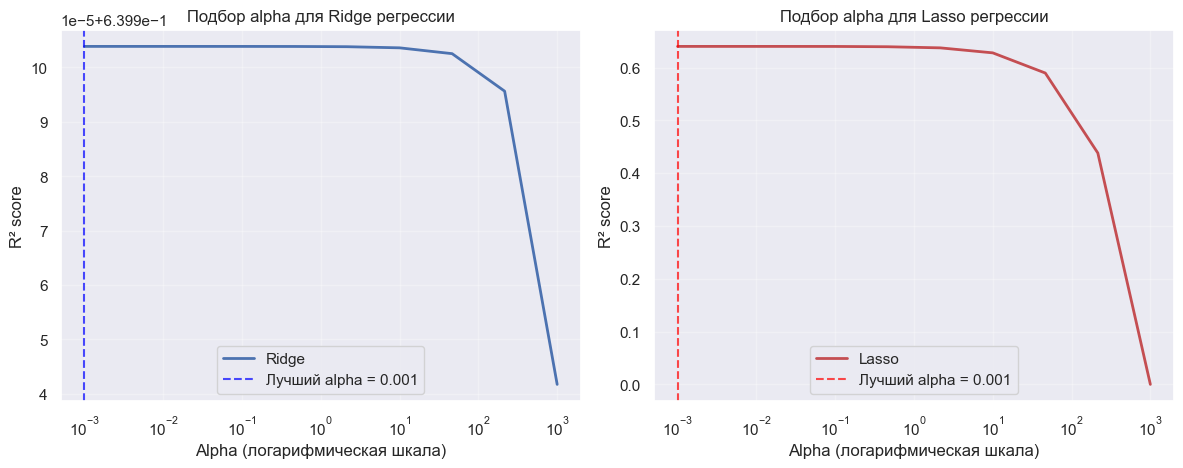


=== ФИНАЛЬНЫЕ МОДЕЛИ С ОПТИМАЛЬНЫМИ ALPHA ===


c:\Users\ivan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4, 7, 8, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\ivan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4, 7, 8, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ===
Ridge с оптимальным alpha:
  R² Score: 0.0278
  MAE: 368.62
  RMSE: 3119.98

Lasso с оптимальным alpha:
  R² Score: 0.0278
  MAE: 368.62
  RMSE: 3119.98

=== СРАВНЕНИЕ С МОДЕЛЯМИ БЕЗ ПОДБОРА ALPHA ===
Ridge (alpha=1.0):
  R² Score: 0.0278
Lasso (alpha=1.0):
  R² Score: 0.0276

Улучшение Ridge: +0.0000
Улучшение Lasso: +0.0003


In [358]:
# 1. Разбиваем обучающую выборку на train/validation (8:2)
from sklearn.model_selection import train_test_split


X_train_full = train_data.drop('trip_duration', axis=1)
y_train_full = train_data['trip_duration']

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle=True
)

print("=== РАЗБИЕНИЕ ДАННЫХ ===")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Валидационная выборка: {X_val.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# 2. Логарифмическая сетка для alpha
alphas = np.logspace(-3, 3, 10)  # от 0.001 до 1000
print(f"\nЛогарифмическая сетка alpha: ")
print(alphas)

# 3. Подбор оптимального alpha на валидационной выборке
best_alpha_ridge = None
best_score_ridge = -np.inf
best_alpha_lasso = None
best_score_lasso = -np.inf

ridge_scores = []
lasso_scores = []

print("\n=== ПОДБОР ОПТИМАЛЬНОГО ALPHA ===")

for alpha in alphas:
    # Ridge регрессия
    ridge_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=alpha, random_state=42))
    ])
    ridge_pipeline.fit(X_train, y_train)
    ridge_score = ridge_pipeline.score(X_val, y_val)
    ridge_scores.append(ridge_score)
    
    if ridge_score > best_score_ridge:
        best_score_ridge = ridge_score
        best_alpha_ridge = alpha
    
    # Lasso регрессия
    lasso_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=alpha, random_state=42, max_iter=10000))
    ])
    lasso_pipeline.fit(X_train, y_train)
    lasso_score = lasso_pipeline.score(X_val, y_val)
    lasso_scores.append(lasso_score)
    
    if lasso_score > best_score_lasso:
        best_score_lasso = lasso_score
        best_alpha_lasso = alpha
    print(f'Alpha {alpha} counted;')

print(f"Лучший alpha для Ridge: {best_alpha_ridge:.4f} (R² = {best_score_ridge:.4f})")
print(f"Лучший alpha для Lasso: {best_alpha_lasso:.4f} (R² = {best_score_lasso:.4f})")

# 4. Визуализация подбора alpha
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogx(alphas, ridge_scores, 'b-', linewidth=2, label='Ridge')
plt.axvline(best_alpha_ridge, color='blue', linestyle='--', alpha=0.7, label=f'Лучший alpha = {best_alpha_ridge:.3f}')
plt.xlabel('Alpha (логарифмическая шкала)')
plt.ylabel('R² score')
plt.title('Подбор alpha для Ridge регрессии')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogx(alphas, lasso_scores, 'r-', linewidth=2, label='Lasso')
plt.axvline(best_alpha_lasso, color='red', linestyle='--', alpha=0.7, label=f'Лучший alpha = {best_alpha_lasso:.3f}')
plt.xlabel('Alpha (логарифмическая шкала)')
plt.ylabel('R² score')
plt.title('Подбор alpha для Lasso регрессии')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Обучение финальных моделей с лучшими alpha
print("\n=== ФИНАЛЬНЫЕ МОДЕЛИ С ОПТИМАЛЬНЫМИ ALPHA ===")

# Ridge с оптимальным alpha
final_ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=best_alpha_ridge, random_state=42))
])
final_ridge_pipeline.fit(X_train_full, y_train_full)
y_pred_ridge_final = final_ridge_pipeline.predict(X_test)

# Lasso с оптимальным alpha
final_lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000))
])
final_lasso_pipeline.fit(X_train_full, y_train_full)
y_pred_lasso_final = final_lasso_pipeline.predict(X_test)

# 6. Оценка качества на тестовой выборке
print("\n=== РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ ===")
print("Ridge с оптимальным alpha:")
print(f"  R² Score: {r2_score(y_test, y_pred_ridge_final):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_ridge_final):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge_final)):.2f}")

print("\nLasso с оптимальным alpha:")
print(f"  R² Score: {r2_score(y_test, y_pred_lasso_final):.4f}")
print(f"  MAE: {mean_absolute_error(y_test, y_pred_lasso_final):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso_final)):.2f}")

# 7. Сравнение с моделями без подбора alpha
print(f"\n=== СРАВНЕНИЕ С МОДЕЛЯМИ БЕЗ ПОДБОРА ALPHA ===")
print("Ridge (alpha=1.0):")
print(f"  R² Score: {r2_score(y_test, y_pred):.4f}")

print("Lasso (alpha=1.0):")
print(f"  R² Score: {r2_score(y_test, y_pred_lasso):.4f}")

# Анализ улучшения
ridge_improvement = r2_score(y_test, y_pred_ridge_final) - r2_score(y_test, y_pred)
lasso_improvement = r2_score(y_test, y_pred_lasso_final) - r2_score(y_test, y_pred_lasso)

print(f"\nУлучшение Ridge: {ridge_improvement:+.4f}")
print(f"Улучшение Lasso: {lasso_improvement:+.4f}")

Для каждого перебранного `alpha` посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`.

=== ПОДСЧЕТ НУЛЕВЫХ ВЕСОВ ДЛЯ РАЗНЫХ ALPHA ===
alpha = 0.0010: 0 нулевых весов из 21 (0.0%)
alpha = 2.1544: 8 нулевых весов из 21 (38.1%)
alpha = 1000.0000: 21 нулевых весов из 21 (100.0%)


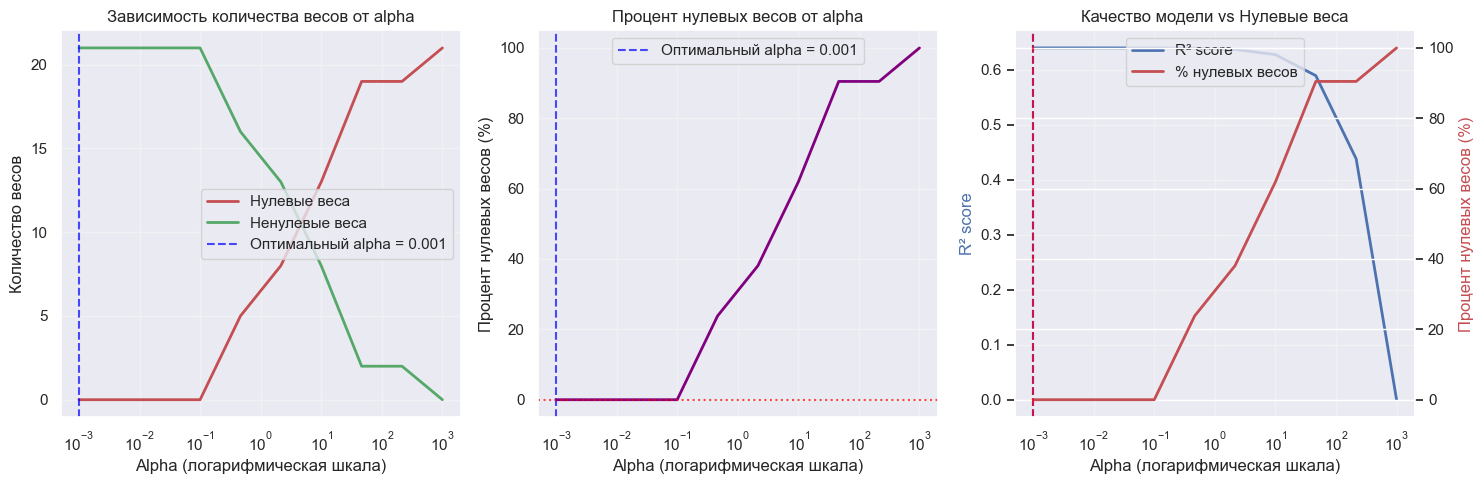


=== АНАЛИЗ ДЛЯ ОПТИМАЛЬНОГО ALPHA (0.0010) ===
Нулевые веса: 0 из 21 (0.0%)
Ненулевые веса: 21 из 21 (100.0%)


ValueError: All arrays must be of the same length

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

zero_weights_counts = []
non_zero_counts = []

print("=== ПОДСЧЕТ НУЛЕВЫХ ВЕСОВ ДЛЯ РАЗНЫХ ALPHA ===")

for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    lasso.fit(X_train_preprocessed, y_train)
    
    zero_weights = np.sum(lasso.coef_ == 0)
    non_zero_weights = np.sum(lasso.coef_ != 0)
    total_weights = len(lasso.coef_)
    
    zero_weights_counts.append(zero_weights)
    non_zero_counts.append(non_zero_weights)
    
    if alpha in [alphas[0], alphas[len(alphas)//2], alphas[-1]]:
        print(f"alpha = {alpha:.4f}: {zero_weights} нулевых весов из {total_weights} ({zero_weights/total_weights*100:.1f}%)")

plt.figure(figsize=(15, 5))

# График 1: Количество нулевых весов
plt.subplot(1, 3, 1)
plt.semilogx(alphas, zero_weights_counts, 'r-', linewidth=2, label='Нулевые веса')
plt.semilogx(alphas, non_zero_counts, 'g-', linewidth=2, label='Ненулевые веса')
plt.axvline(best_alpha_lasso, color='blue', linestyle='--', alpha=0.7, 
           label=f'Оптимальный alpha = {best_alpha_lasso:.3f}')
plt.xlabel('Alpha (логарифмическая шкала)')
plt.ylabel('Количество весов')
plt.title('Зависимость количества весов от alpha')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Процент нулевых весов
plt.subplot(1, 3, 2)
percent_zero = [zero/total_weights*100 for zero, total in zip(zero_weights_counts, [total_weights]*len(alphas))]
plt.semilogx(alphas, percent_zero, 'purple', linewidth=2)
plt.axvline(best_alpha_lasso, color='blue', linestyle='--', alpha=0.7, 
           label=f'Оптимальный alpha = {best_alpha_lasso:.3f}')
plt.axhline(percent_zero[np.where(alphas == best_alpha_lasso)[0][0]], color='red', linestyle=':', alpha=0.7)
plt.xlabel('Alpha (логарифмическая шкала)')
plt.ylabel('Процент нулевых весов (%)')
plt.title('Процент нулевых весов от alpha')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Совмещенный график - качество и нулевые веса
plt.subplot(1, 3, 3)
ax1 = plt.gca()
ax2 = ax1.twinx()

# Качество модели (R²)
line1 = ax1.semilogx(alphas, lasso_scores, 'b-', linewidth=2, label='R² score')
ax1.axvline(best_alpha_lasso, color='blue', linestyle='--', alpha=0.7)

# Нулевые веса
line2 = ax2.semilogx(alphas, percent_zero, 'r-', linewidth=2, label='% нулевых весов')
ax2.axvline(best_alpha_lasso, color='red', linestyle='--', alpha=0.7)

ax1.set_xlabel('Alpha (логарифмическая шкала)')
ax1.set_ylabel('R² score', color='b')
ax2.set_ylabel('Процент нулевых весов (%)', color='r')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center')

plt.title('Качество модели vs Нулевые веса')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== АНАЛИЗ ДЛЯ ОПТИМАЛЬНОГО ALPHA ({best_alpha_lasso:.4f}) ===")
optimal_lasso = Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000)
optimal_lasso.fit(X_train_preprocessed, y_train)

zero_weights_optimal = np.sum(optimal_lasso.coef_ == 0)
non_zero_optimal = np.sum(optimal_lasso.coef_ != 0)
total_weights = len(optimal_lasso.coef_)

print(f"Нулевые веса: {zero_weights_optimal} из {total_weights} ({zero_weights_optimal/total_weights*100:.1f}%)")
print(f"Ненулевые веса: {non_zero_optimal} из {total_weights} ({non_zero_optimal/total_weights*100:.1f}%)")

# 5. Анализ самых важных признаков при оптимальном alpha
feature_names = []
# Числовые признаки
feature_names.extend(numerical_features)
# Категориальные признаки после OneHot
for i, feature in enumerate(categorical_features):
    categories = preprocessor.named_transformers_['cat'].categories_[i]
    for j in range(1, len(categories)):  # начинаем с 1 из-за drop='first'
        feature_names.append(f"{feature}_{categories[j]}")
plt.tight_layout()
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15.** Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими редкими парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
# 1. Создаем пары start_cell и end_cell для train_data
grid_transformer = MapGridTransformer()
grid_transformer.fit(train_data[coord_features])
cells = grid_transformer.transform(train_data[coord_features])

# Добавляем как отдельные колонки
train_data['start_cell'] = cells[:, 0]  # первая колонка
train_data['end_cell'] = cells[:, 1]    # вторая колонка
train_data['cell_pair'] = list(zip(train_data['start_cell'], train_data['end_cell']))

# 1. Создаем пары start_cell и end_cell для train_data
grid_transformer = MapGridTransformer()
grid_transformer.fit(test_data[coord_features])
cells = grid_transformer.transform(test_data[coord_features])

# Добавляем как отдельные колонки
test_data['start_cell'] = cells[:, 0]  # первая колонка
test_data['end_cell'] = cells[:, 1]    # вторая колонка
test_data['cell_pair'] = list(zip(test_data['start_cell'], test_data['end_cell']))


# 2. Считаем частоты пар только по train_data
pair_counts = train_data['cell_pair'].value_counts()
print(f"Всего уникальных пар в train_data: {len(pair_counts)}")

# 3. Выбираем 100 самых частых пар из train_data
top_100_pairs = list(pair_counts.head(100).index)
print(f"\nТоп-10 самых частых пар в train_data:")
for i, pair in enumerate(top_100_pairs[:10]):
    count = pair_counts[pair]
    print(f"{i+1}. {pair}: {count} поездок ({count/len(train_data)*100:.2f}%)")

# 4. Создаем новый категориальный признак для train_data и test_data
train_data['frequent_route'] = train_data.apply(
    lambda row: top_100_pairs.index((row['start_cell'], row['end_cell'])) 
                if (row['start_cell'], row['end_cell']) in top_100_pairs 
                else -1, 
    axis=1
).astype(str)

test_data['frequent_route'] = test_data.apply(
    lambda row: top_100_pairs.index((row['start_cell'], row['end_cell'])) 
                if (row['start_cell'], row['end_cell']) in top_100_pairs 
                else -1, 
    axis=1
).astype(str)

train_data = train_data.drop('cell_pair', axis=1)
train_data = train_data.drop('start_cell', axis=1)
train_data = train_data.drop('end_cell', axis=1)

test_data = test_data.drop('cell_pair', axis=1)
test_data = test_data.drop('start_cell', axis=1)
test_data = test_data.drop('end_cell', axis=1)


Всего уникальных пар в train_data: 169

Топ-10 самых частых пар в train_data:
1. (-1, -1): 251640 поездок (25.33%)
2. (2, -1): 63083 поездок (6.35%)
3. (-1, 2): 54143 поездок (5.45%)
4. (2, 2): 29082 поездок (2.93%)
5. (1, -1): 28705 поездок (2.89%)
6. (4, -1): 21953 поездок (2.21%)
7. (1, 2): 21787 поездок (2.19%)
8. (5, -1): 19598 поездок (1.97%)
9. (-1, 1): 19164 поездок (1.93%)
10. (2, 1): 19127 поездок (1.93%)


Переобучите модель на новых даннных и посчитайте качество на тестовой выборке

In [371]:
# Определяем координатные признаки для трансформера
coordinate_features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']

# Остальные числовые признаки (без координат)
other_numerical_features = ['passenger_count', 'day_of_year', 'haversine', 'log_haversine']

# Категориальные признаки
categorical_features = ['vendor_id', 'store_and_fwd_flag', 'day_of_week', 'is_snow_period', 'is_second_period', 
                       'is_jam_time', 'is_night', 'pickup_near_JFK', 'dropoff_near_JFK', 
                       'pickup_near_LGA', 'dropoff_near_LGA', 'frequent_route']

preprocessor = ColumnTransformer(
    transformers=[
        ('coords', MapGridTransformer(), coordinate_features),
        ('num', StandardScaler(), other_numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

# Создаем пайплайн
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

X_train = train_data.drop('trip_duration', axis=1)
y_train = train_data['trip_duration']

pipeline.fit(X_train, y_train)

X_test = test_data.drop('trip_duration', axis=1)
y_test = test_data['trip_duration']

y_pred = pipeline.predict(X_test)

print("=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

c:\Users\ivan\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4, 7, 8, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== ОЦЕНКА КАЧЕСТВА МОДЕЛИ ===
R² Score: 0.0284
MAE: 361.51
RMSE: 3119.01
